## Requirement : Mobile price depends on various factors such as resolution, brand, size, weight, imaging quality, RAM, battery and cpu power. In this dataset, we want to estimate the price of mobile phones using the above features

#### i.	Download the dataset from above link and load it into your Python environment.
#### ii.	Perform the EDA and do the visualizations.
#### iii.	Check the distributions/skewness in the variables and do the transformations if required.
#### iv.	Check/Treat the outliers and do the feature scaling if required.
#### v.	Create a ML model to predict the price of the phone based on the specifications given.
#### vi.	Check for overfitting and use the Regularization techniques if required
#### vii.	Compare the performance metrics of training dataset and testing dataset for all the different algorithms used (Linear/Ridge/Lasso/ElasticNet)


<div style="background-color: #322f3d; color: white; padding: 15px; border-radius: 8px; font-size: 20px; font-weight: bold;">
  <span style="color: orange;">1</span> | Importing Libraries
</div>

In [6]:
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb
import missingno as msno

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
#from statsforecast.losses import smape
from pandas.plotting import scatter_matrix
from scipy.stats import skew ,boxcox
from sklearn.ensemble import GradientBoostingRegressor , RandomForestRegressor , AdaBoostClassifier
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge , LassoCV , RidgeCV , ElasticNetCV 
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score , train_test_split , KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler ,RobustScaler

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from scipy.special import inv_boxcox 
from scipy.stats import yeojohnson


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd
import numpy as np
from scipy.stats import boxcox, yeojohnson, skew

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor


sns.set()
%matplotlib inline

### Libraries Used

In [7]:
libraries = {
    "numpy": "np",
    "pandas": "pd",
    "scipy": "scipy",
    "statsmodels": "statsmodels",
    "matplotlib": "matplotlib",
    "seaborn": "sns",
    "plotly": "plotly",
    "scikit-learn": "sklearn",
    "xgboost": "xgboost",
    "catboost": "catboost",
    "lightgbm": "lightgbm"
}

# Dictionary to store library versions
library_versions = {}

# Check and print versions for each library
for lib in libraries.keys():
    try:
        # Special case for scikit-learn to debug the import explicitly
        if lib == "scikit-learn":
            import sklearn
            library_versions[lib] = sklearn.__version__
        else:
            module = __import__(lib)
            library_versions[lib] = module.__version__
    except ModuleNotFoundError:
        library_versions[lib] = "Not installed"
    except Exception as e:
        library_versions[lib] = f"Error: {str(e)}"

# Display results
for lib, version in library_versions.items():
    if version == "Not installed":
        print(f"{lib}: Not installed. Install using 'pip install {lib}'")
    else:
        print(f"{lib}: {version}")


numpy: 1.26.4
pandas: 2.2.2
scipy: 1.15.3
statsmodels: 0.14.2
matplotlib: 3.9.2
seaborn: 0.13.2
plotly: 5.24.1
scikit-learn: 1.5.1
xgboost: 3.0.0
catboost: 1.2.8
lightgbm: 4.6.0


# Explorative Data Analysis

## Data Read

In [8]:
name ="mobile"

In [9]:
mobile = pd.read_csv("Cellphone.csv")

In [10]:
mobile

Product_id  Price  Sale  weight  resoloution  ppi  cpu core  cpu freq  \
0           203   2357    10   135.0         5.20  424         8     1.350   
1           880   1749    10   125.0         4.00  233         2     1.300   
2            40   1916    10   110.0         4.70  312         4     1.200   
3            99   1315    11   118.5         4.00  233         2     1.300   
4           880   1749    11   125.0         4.00  233         2     1.300   
..          ...    ...   ...     ...          ...  ...       ...       ...   
156        1206   3551  4638   178.0         5.46  538         4     1.875   
157        1296   3211  8016   170.0         5.50  534         4     1.975   
158         856   3260  8809   150.0         5.50  401         8     2.200   
159        1296   3211  8946   170.0         5.50  534         4     1.975   
160        1131   2536  9807   202.0         6.00  367         8     1.500   

     internal mem    ram  RearCam  Front_Cam  battery  thickness  
0            16.0  3.000    13.00        8.0     2610        7.4  
1             4.0  1.000     3.15        0.0     1700        9.9  
2             8.0  1.500    13.00        5.0     2000        7.6  
3             4.0  0.512     3.15        0.0     1400       11.0  
4             4.0  1.000     3.15        0.0     1700        9.9  
..            ...    ...      ...        ...      ...        ...  
156         128.0  6.000    12.00       16.0     4080        8.4  
157         128.0  6.000    20.00        8.0     3400        7.9  
158          64.0  4.000    20.00       20.0     3000        6.8  
159         128.0  6.000    20.00        8.0     3400        7.9  
160          16.0  3.000    21.50       16.0     2700        8.4  

[161 rows x 14 columns]

In [11]:
mobile = mobile.drop(columns="Product_id")

#  Data Encoding on RAW Data

In [ ]:
def target_encode(df, cat_column, target_column, smoothing=1.0):
    """
    Performs target encoding on a single categorical column.
    
    Parameters:
        df (pd.DataFrame): The dataset
        cat_column (str): Name of the categorical column
        target_column (str): Name of the target column
        smoothing (float): Smoothing factor to reduce overfitting (higher = more smoothing)
        
    Returns:
        encoded_series (pd.Series): Encoded version of the categorical column
        encoding_map (pd.Series): Mapping of category to encoded value
    """
    # Compute mean target per category
    means = df.groupby(cat_column)[target_column].mean()
    counts = df.groupby(cat_column)[target_column].count()
    global_mean = df[target_column].mean()
    
    # Apply smoothing
    smooth = (counts * means + smoothing * global_mean) / (counts + smoothing)
    
    # Map to the original column
    encoded_series = df[cat_column].map(smooth)
    
    return encoded_series, smooth

# To use for higher cardinality
#medical['region_encoded'], region_encoding_map = target_encode(medical, cat_column='region', target_column='charges')

In [12]:
unique_vals ={}
def auto_encode(df):
    df_encoded = df.copy()
    label_encoders = {}
    for col in df_encoded.columns:
        if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
            unique_vals = df_encoded[col].nunique()
            
            # Binary categorical: Use Label Encoding
            if unique_vals == 2:
                le = LabelEncoder()
                df_encoded[col] = le.fit_transform(df_encoded[col])
                label_encoders[col] = le
            else:
                # Multi-class categorical: Use One-Hot Encoding
                df_encoded = pd.get_dummies(df_encoded, columns=[col], prefix=col)

    return df_encoded

In [13]:
mobile = auto_encode(mobile)
if(len(unique_vals) == 0):
    print("No Object label to Encode")
else:
    print("Object label to Encode",unique_vals)
mobile.head()

No Object label to Encode


Price  Sale  weight  resoloution  ppi  cpu core  cpu freq  internal mem  \
0   2357    10   135.0          5.2  424         8      1.35          16.0   
1   1749    10   125.0          4.0  233         2      1.30           4.0   
2   1916    10   110.0          4.7  312         4      1.20           8.0   
3   1315    11   118.5          4.0  233         2      1.30           4.0   
4   1749    11   125.0          4.0  233         2      1.30           4.0   

     ram  RearCam  Front_Cam  battery  thickness  
0  3.000    13.00        8.0     2610        7.4  
1  1.000     3.15        0.0     1700        9.9  
2  1.500    13.00        5.0     2000        7.6  
3  0.512     3.15        0.0     1400       11.0  
4  1.000     3.15        0.0     1700        9.9

# Data Boolean Conversion

In [14]:
def replace_true_false(df):
    #df_replaced = df.copy()
    for col in df.columns:
        if df[col].dtype == bool:
            df[col] = df[col].astype(int)        
        elif df[col].dtype == object:
            df[col] = df[col].astype(str).str.upper()
            df[col] = df[col].replace({'TRUE': 1, 'FALSE': 0})
    
    return df
replace_true_false(mobile)

Price  Sale  weight  resoloution  ppi  cpu core  cpu freq  internal mem  \
0     2357    10   135.0         5.20  424         8     1.350          16.0   
1     1749    10   125.0         4.00  233         2     1.300           4.0   
2     1916    10   110.0         4.70  312         4     1.200           8.0   
3     1315    11   118.5         4.00  233         2     1.300           4.0   
4     1749    11   125.0         4.00  233         2     1.300           4.0   
..     ...   ...     ...          ...  ...       ...       ...           ...   
156   3551  4638   178.0         5.46  538         4     1.875         128.0   
157   3211  8016   170.0         5.50  534         4     1.975         128.0   
158   3260  8809   150.0         5.50  401         8     2.200          64.0   
159   3211  8946   170.0         5.50  534         4     1.975         128.0   
160   2536  9807   202.0         6.00  367         8     1.500          16.0   

       ram  RearCam  Front_Cam  battery  thickness  
0    3.000    13.00        8.0     2610        7.4  
1    1.000     3.15        0.0     1700        9.9  
2    1.500    13.00        5.0     2000        7.6  
3    0.512     3.15        0.0     1400       11.0  
4    1.000     3.15        0.0     1700        9.9  
..     ...      ...        ...      ...        ...  
156  6.000    12.00       16.0     4080        8.4  
157  6.000    20.00        8.0     3400        7.9  
158  4.000    20.00       20.0     3000        6.8  
159  6.000    20.00        8.0     3400        7.9  
160  3.000    21.50       16.0     2700        8.4  

[161 rows x 13 columns]

# Title Correction

In [15]:
mobile.columns = mobile.columns.str.strip().str.lower().str.replace(' ', '_')

In [16]:
target_column_name= "price"

In [17]:
mobile

price  sale  weight  resoloution  ppi  cpu_core  cpu_freq  internal_mem  \
0     2357    10   135.0         5.20  424         8     1.350          16.0   
1     1749    10   125.0         4.00  233         2     1.300           4.0   
2     1916    10   110.0         4.70  312         4     1.200           8.0   
3     1315    11   118.5         4.00  233         2     1.300           4.0   
4     1749    11   125.0         4.00  233         2     1.300           4.0   
..     ...   ...     ...          ...  ...       ...       ...           ...   
156   3551  4638   178.0         5.46  538         4     1.875         128.0   
157   3211  8016   170.0         5.50  534         4     1.975         128.0   
158   3260  8809   150.0         5.50  401         8     2.200          64.0   
159   3211  8946   170.0         5.50  534         4     1.975         128.0   
160   2536  9807   202.0         6.00  367         8     1.500          16.0   

       ram  rearcam  front_cam  battery  thickness  
0    3.000    13.00        8.0     2610        7.4  
1    1.000     3.15        0.0     1700        9.9  
2    1.500    13.00        5.0     2000        7.6  
3    0.512     3.15        0.0     1400       11.0  
4    1.000     3.15        0.0     1700        9.9  
..     ...      ...        ...      ...        ...  
156  6.000    12.00       16.0     4080        8.4  
157  6.000    20.00        8.0     3400        7.9  
158  4.000    20.00       20.0     3000        6.8  
159  6.000    20.00        8.0     3400        7.9  
160  3.000    21.50       16.0     2700        8.4  

[161 rows x 13 columns]

# X Variable CO-relation with Target Variable

In [18]:
def correlation_with_target(df, target_col, method='pearson'):
    if df is None or not isinstance(df, pd.DataFrame):
        raise TypeError("Parameter 'df' must be a pandas DataFrame.")
    
    if not target_col or target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' must be specified and exist in the DataFrame.")

    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be one of: 'pearson', 'spearman', 'kendall'.")
    
    numeric_df = df.select_dtypes(include='number')
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric.")
    corr_series = numeric_df.corr(method=method)[target_col].drop(target_col)
    correlation_df = corr_series.to_frame(name='Correlation with Target')
    correlation_df['Correlation Level'] = correlation_df['Correlation with Target'].apply(
        lambda x: 'Highly Correlated' if abs(x) >= 0.7
        else 'Moderately Correlated' if abs(x) >= 0.3
        else 'Low Correlation'
    )
    correlation_df['Correlation Direction'] = correlation_df['Correlation with Target'].apply(
        lambda x: 'Positive Correlation' if x >= 0 else 'Negative Correlation'
    )
    correlation_df = correlation_df.reindex(
        correlation_df['Correlation with Target'].abs().sort_values(ascending=False).index
    )
    return correlation_df

In [19]:
correlation_with_target(mobile, target_col='price')

Correlation with Target      Correlation Level  \
ram                          0.896915      Highly Correlated   
ppi                          0.817614      Highly Correlated   
internal_mem                 0.776738      Highly Correlated   
rearcam                      0.739538      Highly Correlated   
cpu_freq                     0.727383      Highly Correlated   
thickness                   -0.716773      Highly Correlated   
cpu_core                     0.686811  Moderately Correlated   
front_cam                    0.675286  Moderately Correlated   
battery                      0.559946  Moderately Correlated   
resoloution                  0.404010  Moderately Correlated   
sale                         0.273263        Low Correlation   
weight                       0.144555        Low Correlation   

             Correlation Direction  
ram           Positive Correlation  
ppi           Positive Correlation  
internal_mem  Positive Correlation  
rearcam       Positive Correlation  
cpu_freq      Positive Correlation  
thickness     Negative Correlation  
cpu_core      Positive Correlation  
front_cam     Positive Correlation  
battery       Positive Correlation  
resoloution   Positive Correlation  
sale          Positive Correlation  
weight        Positive Correlation

In [20]:
mobile.shape

(161, 13)

In [21]:
mobile

price  sale  weight  resoloution  ppi  cpu_core  cpu_freq  internal_mem  \
0     2357    10   135.0         5.20  424         8     1.350          16.0   
1     1749    10   125.0         4.00  233         2     1.300           4.0   
2     1916    10   110.0         4.70  312         4     1.200           8.0   
3     1315    11   118.5         4.00  233         2     1.300           4.0   
4     1749    11   125.0         4.00  233         2     1.300           4.0   
..     ...   ...     ...          ...  ...       ...       ...           ...   
156   3551  4638   178.0         5.46  538         4     1.875         128.0   
157   3211  8016   170.0         5.50  534         4     1.975         128.0   
158   3260  8809   150.0         5.50  401         8     2.200          64.0   
159   3211  8946   170.0         5.50  534         4     1.975         128.0   
160   2536  9807   202.0         6.00  367         8     1.500          16.0   

       ram  rearcam  front_cam  battery  thickness  
0    3.000    13.00        8.0     2610        7.4  
1    1.000     3.15        0.0     1700        9.9  
2    1.500    13.00        5.0     2000        7.6  
3    0.512     3.15        0.0     1400       11.0  
4    1.000     3.15        0.0     1700        9.9  
..     ...      ...        ...      ...        ...  
156  6.000    12.00       16.0     4080        8.4  
157  6.000    20.00        8.0     3400        7.9  
158  4.000    20.00       20.0     3000        6.8  
159  6.000    20.00        8.0     3400        7.9  
160  3.000    21.50       16.0     2700        8.4  

[161 rows x 13 columns]

In [22]:
mobile.info

<bound method DataFrame.info of      price  sale  weight  resoloution  ppi  cpu_core  cpu_freq  internal_mem  \
0     2357    10   135.0         5.20  424         8     1.350          16.0   
1     1749    10   125.0         4.00  233         2     1.300           4.0   
2     1916    10   110.0         4.70  312         4     1.200           8.0   
3     1315    11   118.5         4.00  233         2     1.300           4.0   
4     1749    11   125.0         4.00  233         2     1.300           4.0   
..     ...   ...     ...          ...  ...       ...       ...           ...   
156   3551  4638   178.0         5.46  538         4     1.875         128.0   
157   3211  8016   170.0         5.50  534         4     1.975         128.0   
158   3260  8809   150.0         5.50  401         8     2.200          64.0   
159   3211  8946   170.0         5.50  534         4     1.975         128.0   
160   2536  9807   202.0         6.00  367         8     1.500          16.0   

       

In [23]:
mobile.duplicated().sum()

0

In [24]:
mobile.isna().sum()

price           0
sale            0
weight          0
resoloution     0
ppi             0
cpu_core        0
cpu_freq        0
internal_mem    0
ram             0
rearcam         0
front_cam       0
battery         0
thickness       0
dtype: int64

In [25]:
mobile.isnull().sum()

price           0
sale            0
weight          0
resoloution     0
ppi             0
cpu_core        0
cpu_freq        0
internal_mem    0
ram             0
rearcam         0
front_cam       0
battery         0
thickness       0
dtype: int64

## Missing Values %

### How to Decide?
### Situation	Recommended Strategy
### Small % of missing rows	Drop rows
### Numerical columns	Mean/Median/Interpolate
### Categorical columns	Mode or most frequent
### Time-series data	Forward/backward fill
### Complex missing patterns	KNN or model-based imputation

In [26]:
def missing_percentage(mobile):
    missing = mobile.isnull().sum()
    total = mobile.shape[0]
    percent_missing = (missing / total) * 100
    result = pd.DataFrame({
        'Missing Values': missing,
        'Percent Missing': percent_missing.round(2)
    })
    return result[result['Missing Values'] > 0].sort_values(by='Percent Missing', ascending=False)

In [27]:
# Assume df is your DataFrame
missing_report = missing_percentage(mobile)
missing_report

Empty DataFrame
Columns: [Missing Values, Percent Missing]
Index: []

### Total Missing Values

In [28]:
total_missing_values= mobile.isnull().sum().sum()
total_cells = np.product(mobile.shape)
percentage=(total_missing_values/total_cells)*100
print(f"Percentage of missing cells in data is {percentage}")

Percentage of missing cells in data is 0.0


### Treating Missing Values

In [29]:
def impute_missing_values(df):
    df_imputed = df.copy()

    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object' or df[col].dtype.name == 'category':
                # Categorical: use mode
                mode_val = df[col].mode()[0]
                df_imputed[col].fillna(mode_val, inplace=True)
                print(f"Imputed '{col}' with MODE: {mode_val}")
            else:
                # Numeric column
                skew_val = df[col].skew()
                if abs(skew_val) < 0.5:
                    mean_val = df[col].mean()
                    df_imputed[col].fillna(mean_val, inplace=True)
                    print(f"Imputed '{col}' with MEAN: {round(mean_val, 2)} (Skew: {round(skew_val, 2)})")
                else:
                    median_val = df[col].median()
                    df_imputed[col].fillna(median_val, inplace=True)
                    print(f"Imputed '{col}' with MEDIAN: {round(median_val, 2)} (Skew: {round(skew_val, 2)})")
    
    return df_imputed

In [30]:
mobile = impute_missing_values(mobile)

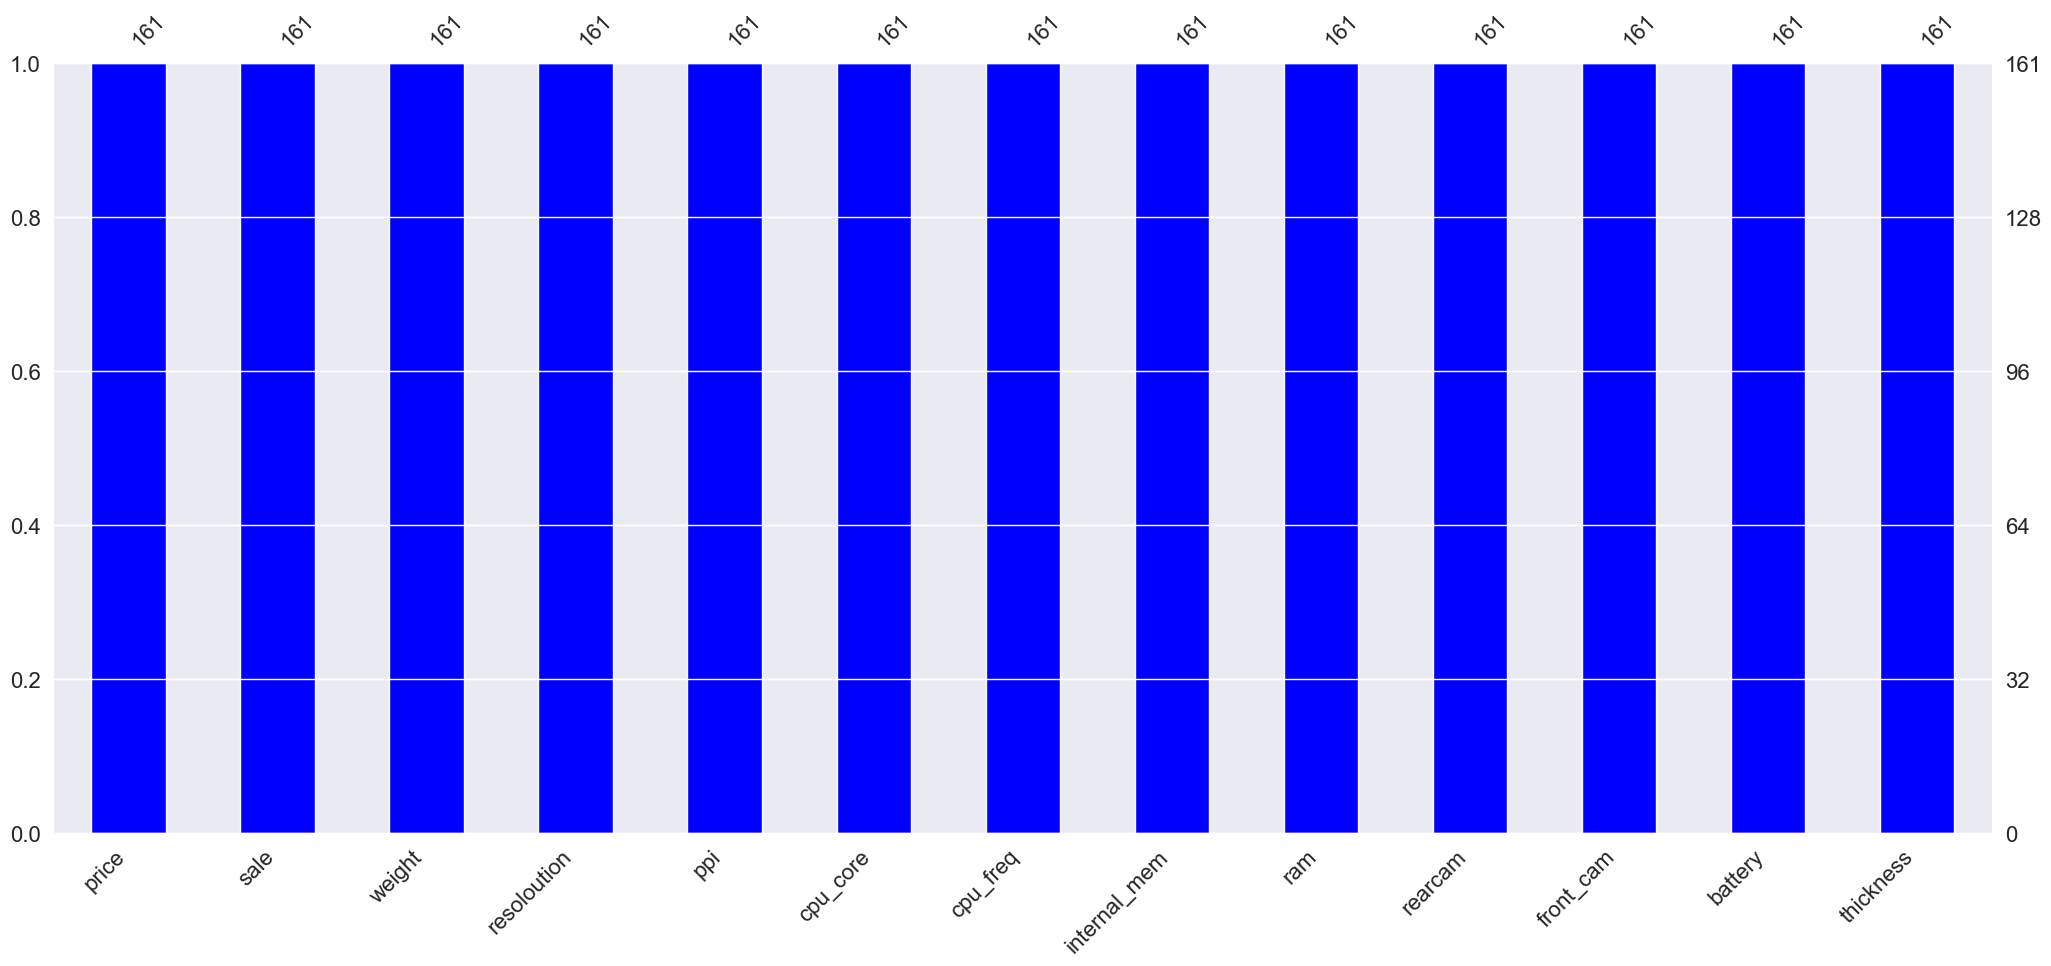

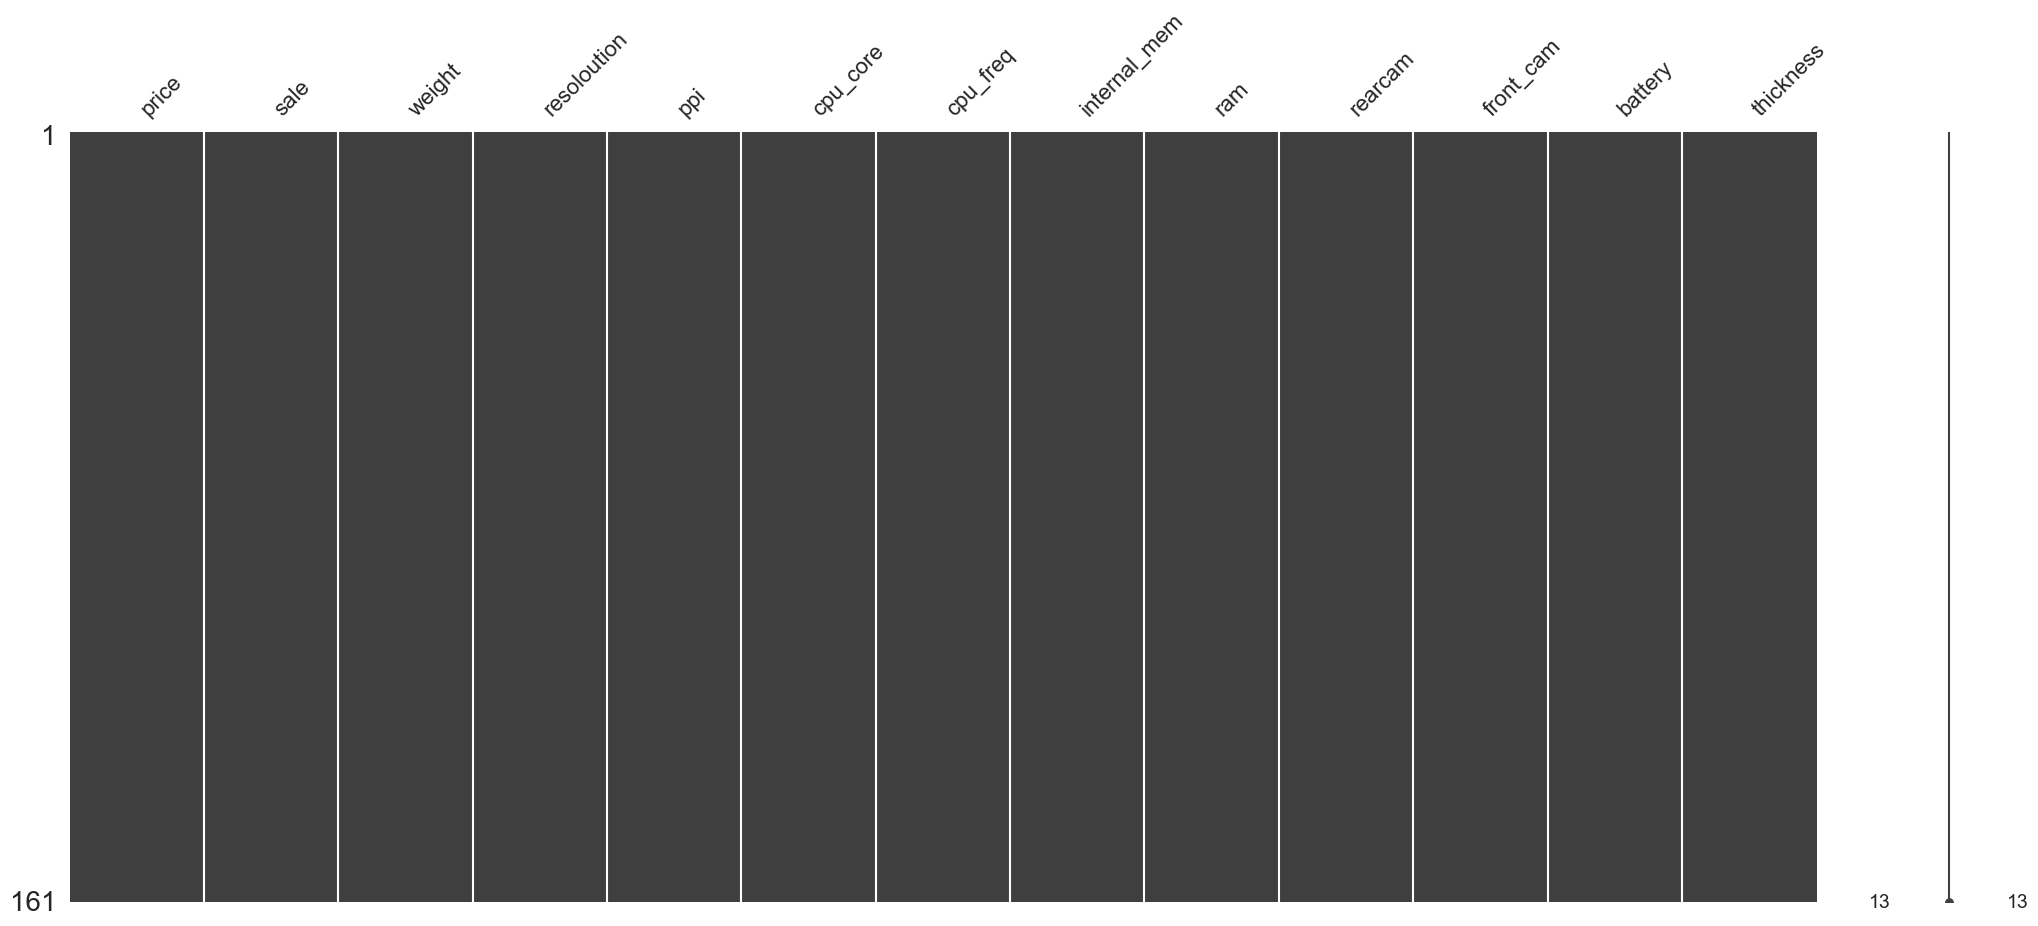

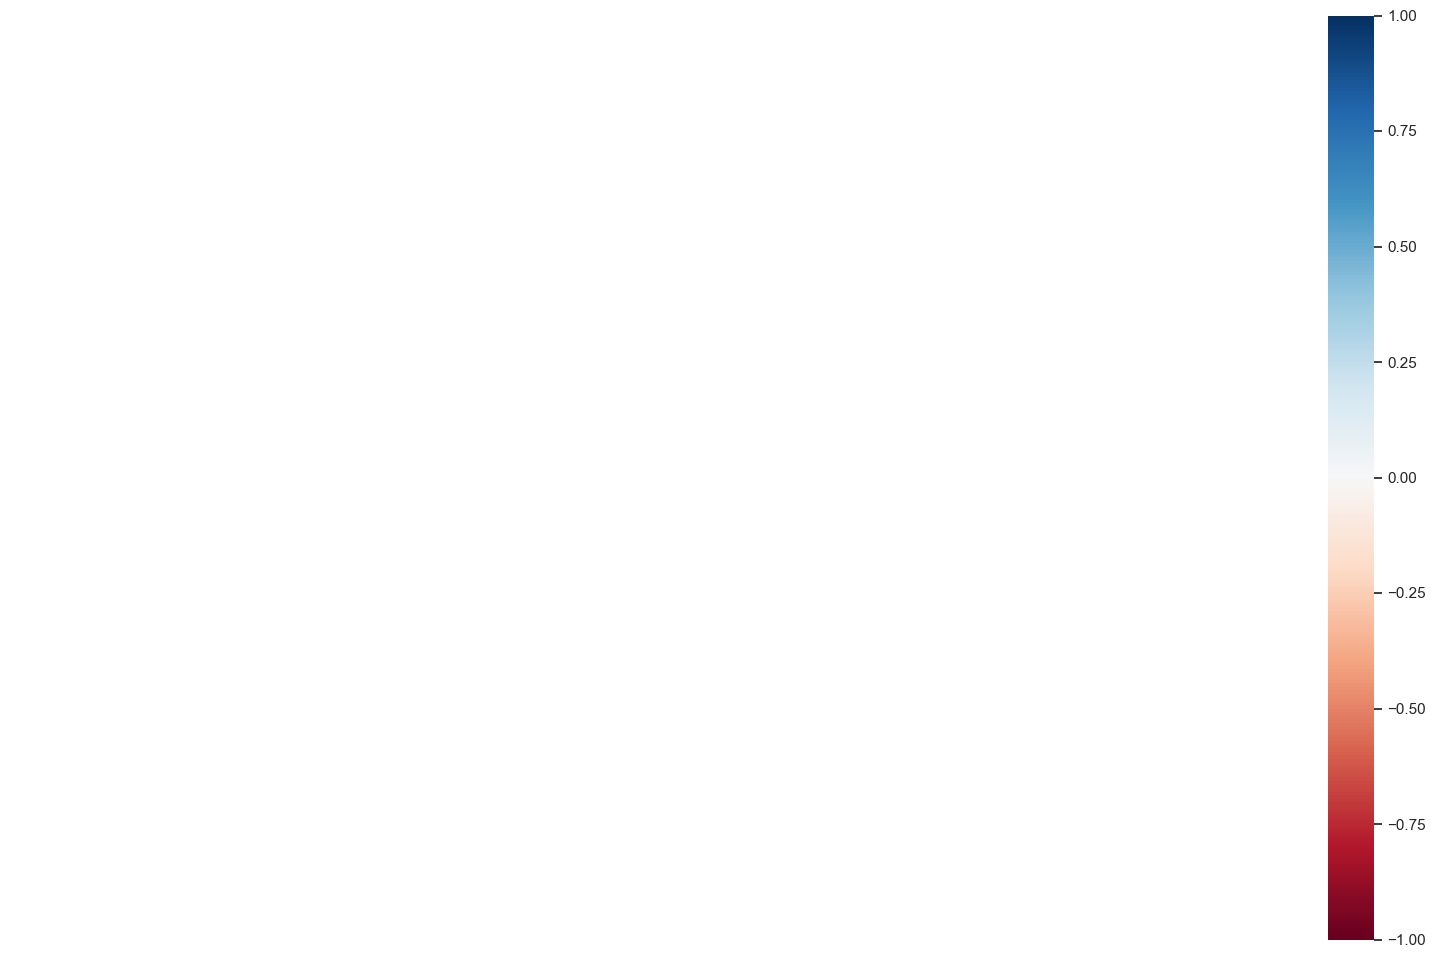

In [31]:
msno.bar(mobile,color="blue")
msno.matrix(mobile)
msno.heatmap(mobile)
plt.show()

## Feature Co-Relation

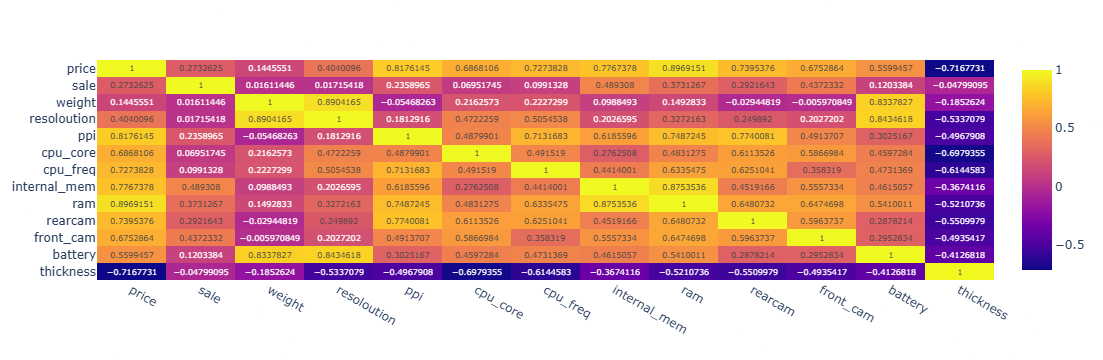

In [32]:
import plotly.express as px
fig = px.imshow(mobile.corr(),text_auto=True,aspect="auto")
fig.show()

In [33]:
round(mobile.corr(),3)

price   sale  weight  resoloution    ppi  cpu_core  cpu_freq  \
price         1.000  0.273   0.145        0.404  0.818     0.687     0.727   
sale          0.273  1.000   0.016        0.017  0.236     0.070     0.099   
weight        0.145  0.016   1.000        0.890 -0.055     0.216     0.223   
resoloution   0.404  0.017   0.890        1.000  0.181     0.472     0.505   
ppi           0.818  0.236  -0.055        0.181  1.000     0.488     0.713   
cpu_core      0.687  0.070   0.216        0.472  0.488     1.000     0.492   
cpu_freq      0.727  0.099   0.223        0.505  0.713     0.492     1.000   
internal_mem  0.777  0.489   0.099        0.203  0.619     0.276     0.441   
ram           0.897  0.373   0.149        0.327  0.749     0.483     0.634   
rearcam       0.740  0.292  -0.029        0.250  0.774     0.611     0.625   
front_cam     0.675  0.437  -0.006        0.203  0.491     0.587     0.358   
battery       0.560  0.120   0.834        0.843  0.303     0.460     0.473   
thickness    -0.717 -0.048  -0.185       -0.534 -0.497    -0.698    -0.614   

              internal_mem    ram  rearcam  front_cam  battery  thickness  
price                0.777  0.897    0.740      0.675    0.560     -0.717  
sale                 0.489  0.373    0.292      0.437    0.120     -0.048  
weight               0.099  0.149   -0.029     -0.006    0.834     -0.185  
resoloution          0.203  0.327    0.250      0.203    0.843     -0.534  
ppi                  0.619  0.749    0.774      0.491    0.303     -0.497  
cpu_core             0.276  0.483    0.611      0.587    0.460     -0.698  
cpu_freq             0.441  0.634    0.625      0.358    0.473     -0.614  
internal_mem         1.000  0.875    0.452      0.556    0.462     -0.367  
ram                  0.875  1.000    0.648      0.647    0.541     -0.521  
rearcam              0.452  0.648    1.000      0.596    0.288     -0.551  
front_cam            0.556  0.647    0.596      1.000    0.295     -0.494  
battery              0.462  0.541    0.288      0.295    1.000     -0.413  
thickness           -0.367 -0.521   -0.551     -0.494   -0.413      1.000

In [34]:
mobile.describe()

price         sale      weight  resoloution         ppi  \
count   161.000000   161.000000  161.000000   161.000000  161.000000   
mean   2215.596273   621.465839  170.426087     5.209938  335.055901   
std     768.187171  1546.618517   92.888612     1.509953  134.826659   
min     614.000000    10.000000   66.000000     1.400000  121.000000   
25%    1734.000000    37.000000  134.100000     4.800000  233.000000   
50%    2258.000000   106.000000  153.000000     5.150000  294.000000   
75%    2744.000000   382.000000  170.000000     5.500000  428.000000   
max    4361.000000  9807.000000  753.000000    12.200000  806.000000   

         cpu_core    cpu_freq  internal_mem         ram     rearcam  \
count  161.000000  161.000000    161.000000  161.000000  161.000000   
mean     4.857143    1.502832     24.501714    2.204994   10.378261   
std      2.444016    0.599783     28.804773    1.609831    6.181585   
min      0.000000    0.000000      0.000000    0.000000    0.000000   
25%      4.000000    1.200000      8.000000    1.000000    5.000000   
50%      4.000000    1.400000     16.000000    2.000000   12.000000   
75%      8.000000    1.875000     32.000000    3.000000   16.000000   
max      8.000000    2.700000    128.000000    6.000000   23.000000   

        front_cam      battery   thickness  
count  161.000000   161.000000  161.000000  
mean     4.503106  2842.111801    8.921739  
std      4.342053  1366.990838    2.192564  
min      0.000000   800.000000    5.100000  
25%      0.000000  2040.000000    7.600000  
50%      5.000000  2800.000000    8.400000  
75%      8.000000  3240.000000    9.800000  
max     20.000000  9500.000000   18.500000

## 3D Plots / Multiple Axes (Visual Insight)

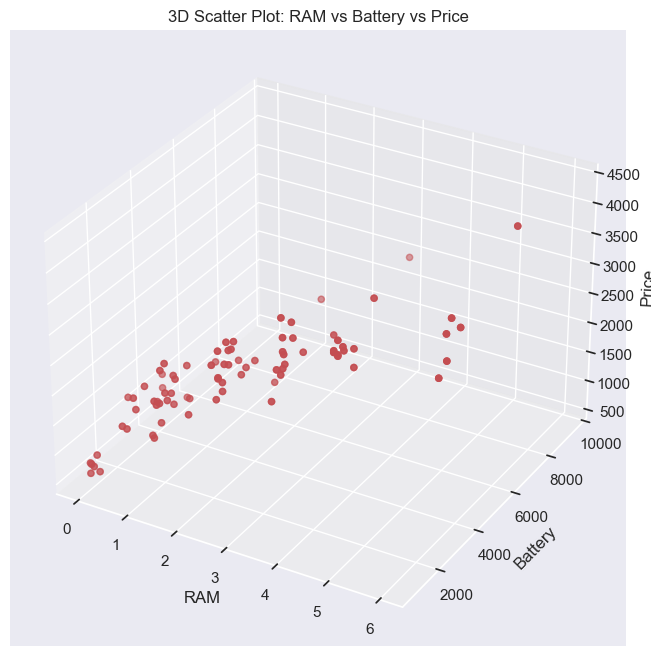

In [35]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mobile['ram'], mobile['battery'], mobile['price'], c='r', marker='o')
ax.set_xlabel('RAM')
ax.set_ylabel('Battery')
ax.set_zlabel('Price')
plt.title("3D Scatter Plot: RAM vs Battery vs Price")
plt.show()

## Pairplot on raw Data(Correlation Visualization)

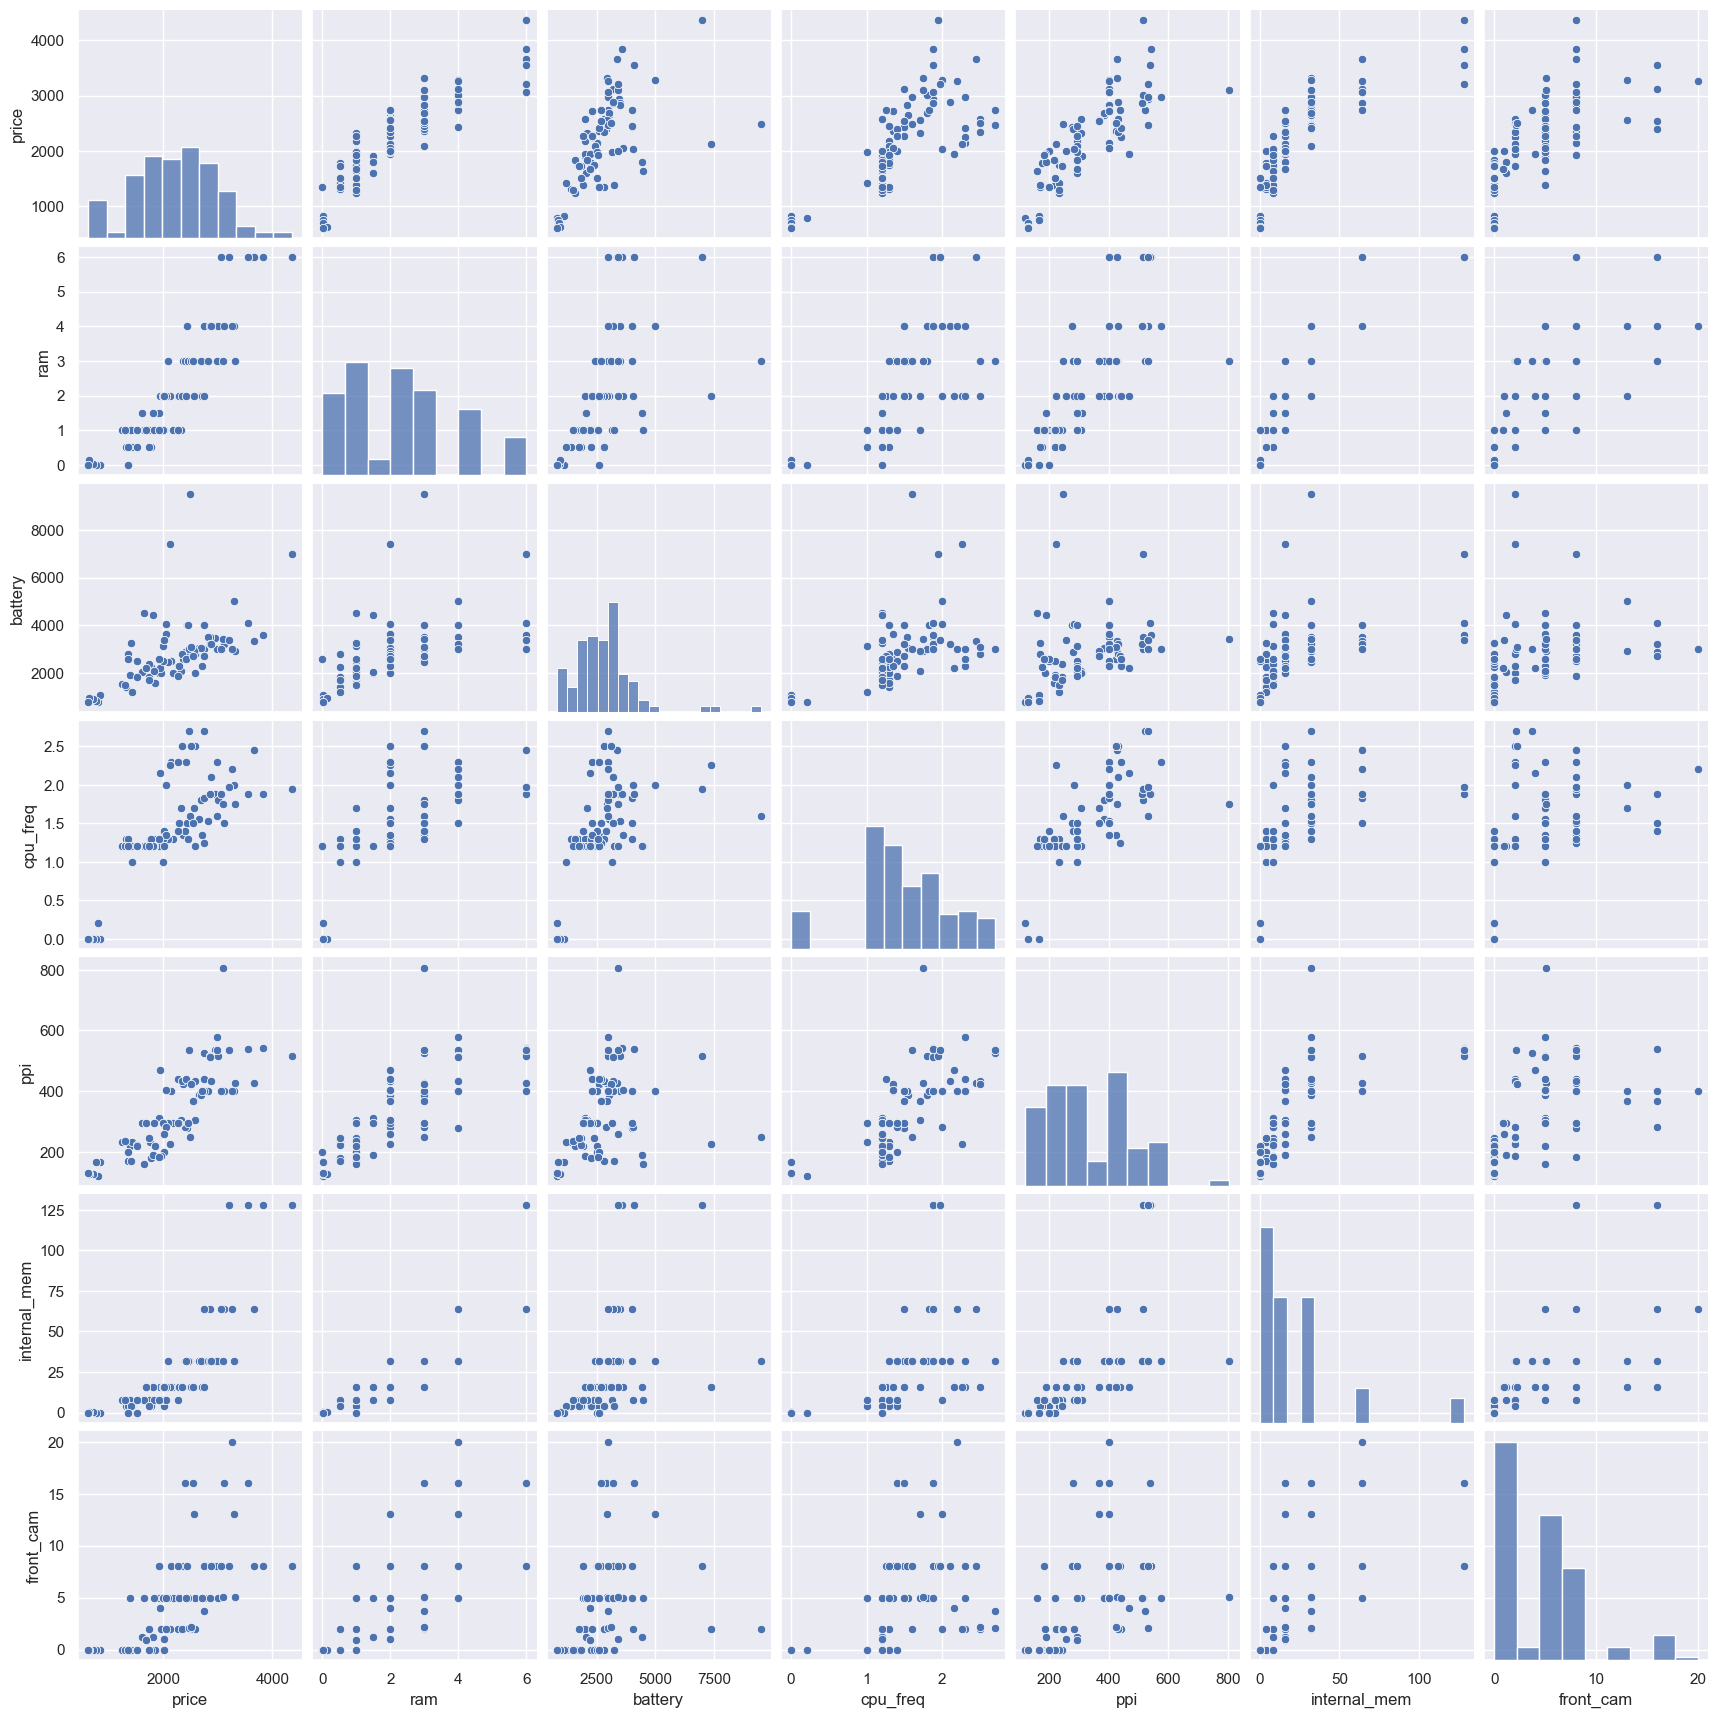

In [36]:
selected_cols = ['price', 'ram', 'battery', 'cpu_freq', 'ppi',"internal_mem","front_cam"]  # choose relevant features
sns.pairplot(mobile[selected_cols])
plt.show()

## MultiCollinearity Detection

In [37]:
def multicolinearity(mobile):
    X = add_constant(mobile)    #This is done because many statistical models require an intercept term.
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    # Drop  column it’s not an actual feature — it's just there for model fitting.
    vif_data = vif_data[vif_data["Feature"] != "const"]
    
    # Add interpretation column
    def interpret_vif(vif):
        if vif < 1.5:
            return "Low"
        elif vif < 5:
            return "Moderate"
        else:
            return "High"
    
    vif_data["Multicollinearity Level"] = vif_data["VIF"].apply(interpret_vif)
    return vif_data

print("Data:")
display(multicolinearity(mobile))

Data:


Feature        VIF Multicollinearity Level
1          price  21.776893                    High
2           sale   1.806700                Moderate
3         weight  22.754533                    High
4    resoloution  22.738360                    High
5            ppi   5.356153                    High
6       cpu_core   3.748371                Moderate
7       cpu_freq   4.126534                Moderate
8   internal_mem   8.001553                    High
9            ram  10.120537                    High
10       rearcam   3.951803                Moderate
11     front_cam   2.834521                Moderate
12       battery  10.529896                    High
13     thickness   5.049609                    High

In [38]:
mobile.corr()

price      sale    weight  resoloution       ppi  cpu_core  \
price         1.000000  0.273263  0.144555     0.404010  0.817614  0.686811   
sale          0.273263  1.000000  0.016114     0.017154  0.235896  0.069517   
weight        0.144555  0.016114  1.000000     0.890416 -0.054683  0.216257   
resoloution   0.404010  0.017154  0.890416     1.000000  0.181292  0.472226   
ppi           0.817614  0.235896 -0.054683     0.181292  1.000000  0.487990   
cpu_core      0.686811  0.069517  0.216257     0.472226  0.487990  1.000000   
cpu_freq      0.727383  0.099133  0.222730     0.505454  0.713168  0.491519   
internal_mem  0.776738  0.489308  0.098849     0.202660  0.618560  0.276251   
ram           0.896915  0.373127  0.149283     0.327216  0.748724  0.483128   
rearcam       0.739538  0.292164 -0.029448     0.249892  0.774008  0.611353   
front_cam     0.675286  0.437233 -0.005971     0.202720  0.491371  0.586698   
battery       0.559946  0.120338  0.833783     0.843462  0.302517  0.459728   
thickness    -0.716773 -0.047991 -0.185262    -0.533708 -0.496791 -0.697935   

              cpu_freq  internal_mem       ram   rearcam  front_cam   battery  \
price         0.727383      0.776738  0.896915  0.739538   0.675286  0.559946   
sale          0.099133      0.489308  0.373127  0.292164   0.437233  0.120338   
weight        0.222730      0.098849  0.149283 -0.029448  -0.005971  0.833783   
resoloution   0.505454      0.202660  0.327216  0.249892   0.202720  0.843462   
ppi           0.713168      0.618560  0.748724  0.774008   0.491371  0.302517   
cpu_core      0.491519      0.276251  0.483128  0.611353   0.586698  0.459728   
cpu_freq      1.000000      0.441400  0.633547  0.625104   0.358319  0.473137   
internal_mem  0.441400      1.000000  0.875354  0.451917   0.555733  0.461506   
ram           0.633547      0.875354  1.000000  0.648073   0.647470  0.541001   
rearcam       0.625104      0.451917  0.648073  1.000000   0.596374  0.287821   
front_cam     0.358319      0.555733  0.647470  0.596374   1.000000  0.295283   
battery       0.473137      0.461506  0.541001  0.287821   0.295283  1.000000   
thickness    -0.614458     -0.367412 -0.521074 -0.550998  -0.493542 -0.412682   

              thickness  
price         -0.716773  
sale          -0.047991  
weight        -0.185262  
resoloution   -0.533708  
ppi           -0.496791  
cpu_core      -0.697935  
cpu_freq      -0.614458  
internal_mem  -0.367412  
ram           -0.521074  
rearcam       -0.550998  
front_cam     -0.493542  
battery       -0.412682  
thickness      1.000000

## PCA Analysis - Select Top-k Components from PCA

In [39]:
mobile

price  sale  weight  resoloution  ppi  cpu_core  cpu_freq  internal_mem  \
0     2357    10   135.0         5.20  424         8     1.350          16.0   
1     1749    10   125.0         4.00  233         2     1.300           4.0   
2     1916    10   110.0         4.70  312         4     1.200           8.0   
3     1315    11   118.5         4.00  233         2     1.300           4.0   
4     1749    11   125.0         4.00  233         2     1.300           4.0   
..     ...   ...     ...          ...  ...       ...       ...           ...   
156   3551  4638   178.0         5.46  538         4     1.875         128.0   
157   3211  8016   170.0         5.50  534         4     1.975         128.0   
158   3260  8809   150.0         5.50  401         8     2.200          64.0   
159   3211  8946   170.0         5.50  534         4     1.975         128.0   
160   2536  9807   202.0         6.00  367         8     1.500          16.0   

       ram  rearcam  front_cam  battery  thickness  
0    3.000    13.00        8.0     2610        7.4  
1    1.000     3.15        0.0     1700        9.9  
2    1.500    13.00        5.0     2000        7.6  
3    0.512     3.15        0.0     1400       11.0  
4    1.000     3.15        0.0     1700        9.9  
..     ...      ...        ...      ...        ...  
156  6.000    12.00       16.0     4080        8.4  
157  6.000    20.00        8.0     3400        7.9  
158  4.000    20.00       20.0     3000        6.8  
159  6.000    20.00        8.0     3400        7.9  
160  3.000    21.50       16.0     2700        8.4  

[161 rows x 13 columns]

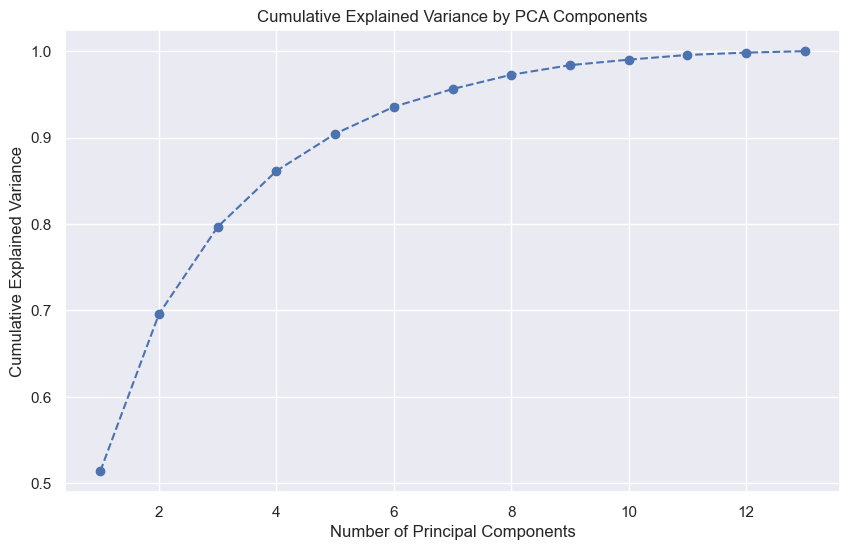

Number of components to retain 90% variance: 7
Original shape: (161, 13)
Transformed shape: (161, 13)
Explained Variance Ratio:


0
0   0.514012
1   0.181983
2   0.100775
3   0.064672
4   0.042994
5   0.031205
6   0.020577
7   0.016509
8   0.011102
9   0.006355
10  0.005442
11  0.002701
12  0.001673

array([[ 1.04742637, -0.53758336, -1.09280463, ...,  0.4169839 ,
        -0.31741515, -0.07544347],
       [-2.63208946, -0.18200662, -0.09224521, ...,  0.16883101,
         0.25710991,  0.07380681],
       [-0.80042881, -0.60423517, -0.84257287, ...,  0.04245056,
        -0.13135971, -0.0187476 ],
       ...,
       [ 4.62129888, -2.50976087,  2.86159805, ..., -0.06913729,
         0.18560686,  0.0882989 ],
       [ 4.59871278, -2.62340299,  4.60904534, ..., -0.14236253,
        -0.2397967 , -0.03905517],
       [ 2.9327497 , -1.67551457,  2.96823128, ...,  0.6656302 ,
         0.26130041, -0.10800053]])

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(mobile)

n_components=13
pca = PCA(n_components)
X_reduced = pca.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

pca_components = pd.DataFrame(pca.components_, columns=mobile.columns)
#print(pca_components.head())

n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.95) + 1
print(f"Number of components to retain 90% variance: {n_components}")

print("Original shape:", X_scaled.shape)
print("Transformed shape:", X_reduced.shape)

print("Explained Variance Ratio:") 
display(pd.DataFrame(pca.explained_variance_ratio_))
display(X_reduced)

# Skew Catagory

In [1]:
def categorize_skew(value):
    """Categorize skewness based on its magnitude."""
    if abs(value) > 1:
        return 'Highly Skewed'
    elif abs(value) > 0.5:
        return 'Moderately Skewed'
    else:
        return 'Approximately Symmetric'

def skew_summary_table(df):
    
    numeric_df = df.select_dtypes(include=['number'])  # Only numeric columns
    skew_values = numeric_df.skew()                    # Compute skewness
    skew_categories = skew_values.apply(categorize_skew)

    summary_df = pd.DataFrame({
        'Skewness': skew_values,
        'Category': skew_categories
    }).sort_values(by='Skewness', ascending=False)

    return summary_df
skew_summary_table(mobile)

NameError: name 'mobile' is not defined

## Outlier Detection

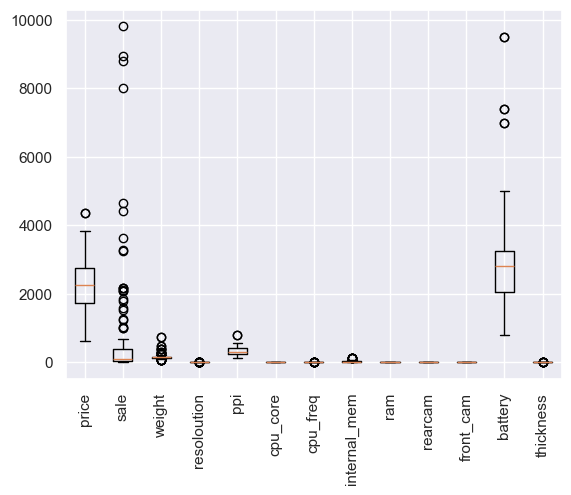

In [41]:
plt.boxplot(mobile,labels=mobile.columns )
plt.xticks(rotation=90)
plt.show()

## Skew, Spread and variance of each variable

In [42]:
mobile.skew()

price           0.052347
sale            4.269384
weight          3.981756
resoloution     1.176110
ppi             0.602503
cpu_core       -0.009077
cpu_freq       -0.512663
internal_mem    2.389683
ram             0.792698
rearcam         0.106929
front_cam       1.169750
battery         2.092660
thickness       1.587680
dtype: float64

In [43]:
def price_vs_var(col):
    #plt.figure(figsize=(10,6))
    sns.histplot(mobile[col],kde=True,color='blue')
    #plt.show() 

cols_to_use = [col for col in mobile.columns if (col !="product_id") ]
for col in cols_to_use:
    price_vs_var(col)

# Part I - Outlier Treatment for each variable by IQR and Other method

In [44]:
mobile.shape

(161, 13)

In [45]:
def iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr_value = q3 - q1
    lower_bound = q1 - (1.5 * iqr_value)
    upper_bound = q3 + (1.5 * iqr_value)

    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    num_outliers = outliers.sum()
    total = df.shape[0]
    outlier_percent = (num_outliers / total) * 100

    # Apply treatment based on rules
    if outlier_percent <= 1:
        treatment = "No Treatment"
    elif outlier_percent <= 10:
        treatment = "Mean Imputation"
        mean_val = df.loc[~outliers, col].mean()
        df.loc[outliers, col] = mean_val
    elif outlier_percent <= 20:
        treatment = "Capping"
        df.loc[df[col] < lower_bound, col] = lower_bound
        df.loc[df[col] > upper_bound, col] = upper_bound
    elif outlier_percent >= 20:
        treatment = "Flagged for Row Removal,transformation, or binning"
    return num_outliers, outlier_percent, treatment, df

In [46]:
def outlier(df):
    #data = df.copy()
    
    cols_to_use = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
    outlier_summary = []
    
    for col in cols_to_use:
        num_outliers, percent, treatment, df_iqr = iqr(df, col)
        outlier_summary.append({
            "Column": col,
            "Num Outliers": num_outliers,
            "Outlier %": round(percent, 2),
            "Treatment Applied": treatment
        })
    outlier_table = pd.DataFrame(outlier_summary)
    display(outlier_table)
    return df_iqr

In [47]:
mobile_iqr = outlier(mobile)
mobile_iqr

Column  Num Outliers  Outlier % Treatment Applied
0          price             2       1.24   Mean Imputation
1           sale            24      14.91           Capping
2         weight            24      14.91           Capping
3    resoloution            26      16.15           Capping
4            ppi             2       1.24   Mean Imputation
5       cpu_core             0       0.00      No Treatment
6       cpu_freq            10       6.21   Mean Imputation
7   internal_mem             8       4.97   Mean Imputation
8            ram             0       0.00      No Treatment
9        rearcam             0       0.00      No Treatment
10     front_cam             0       0.00      No Treatment
11       battery             6       3.73   Mean Imputation
12     thickness             8       4.97   Mean Imputation

price   sale  weight  resoloution    ppi  cpu_core  cpu_freq  \
0    2357.0   10.0   135.0         5.20  424.0         8     1.350   
1    1749.0   10.0   125.0         4.00  233.0         2     1.300   
2    1916.0   10.0   110.0         4.70  312.0         4     1.200   
3    1315.0   11.0   118.5         4.00  233.0         2     1.300   
4    1749.0   11.0   125.0         4.00  233.0         2     1.300   
..      ...    ...     ...          ...    ...       ...       ...   
156  3551.0  899.5   178.0         5.46  538.0         4     1.875   
157  3211.0  899.5   170.0         5.50  534.0         4     1.975   
158  3260.0  899.5   150.0         5.50  401.0         8     2.200   
159  3211.0  899.5   170.0         5.50  534.0         4     1.975   
160  2536.0  899.5   202.0         6.00  367.0         8     1.500   

     internal_mem    ram  rearcam  front_cam  battery  thickness  
0       16.000000  3.000    13.00        8.0   2610.0        7.4  
1        4.000000  1.000     3.15        0.0   1700.0        9.9  
2        8.000000  1.500    13.00        5.0   2000.0        7.6  
3        4.000000  0.512     3.15        0.0   1400.0       11.0  
4        4.000000  1.000     3.15        0.0   1700.0        9.9  
..            ...    ...      ...        ...      ...        ...  
156     19.090039  6.000    12.00       16.0   4080.0        8.4  
157     19.090039  6.000    20.00        8.0   3400.0        7.9  
158     64.000000  4.000    20.00       20.0   3000.0        6.8  
159     19.090039  6.000    20.00        8.0   3400.0        7.9  
160     16.000000  3.000    21.50       16.0   2700.0        8.4  

[161 rows x 13 columns]

#### Outlier % Range	Category	Interpretation
##### 0–1%	None/Negligible	Can be ignored; safe to keep
##### 1–10%	Low	Normal variability; imputation is okay -Mean/Median Imputation
##### 10–20%	Moderate	Needs capping or transformation
##### >20%	High	Strong deviation; risky - Transformation (e.g. log, Yeo-Johnson)
##### >30–40%	Very High	Consider transformation or removal -Consider row removal or binning

In [48]:
mobile.shape

(161, 13)

In [49]:
mobile_iqr.shape

(161, 13)

## Before Outlier Treatment

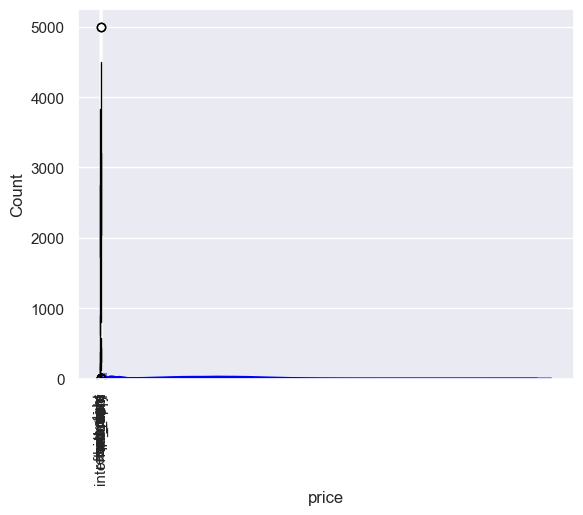

In [50]:
plt.boxplot(mobile,labels=mobile.columns )
plt.xticks(rotation=90)
plt.show()

## After Outlier Treatment

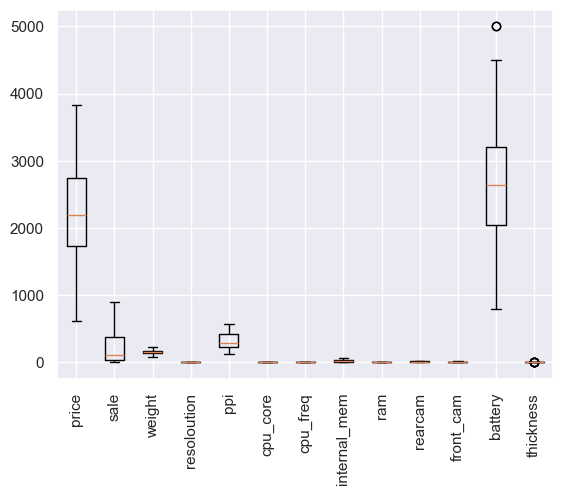

In [51]:
plt.boxplot(mobile_iqr,labels=mobile_iqr.columns )
plt.xticks(rotation=90)
plt.show()

## Skewness Detection and Transformation

In [52]:
mobile.skew()

price          -0.148601
sale            1.250054
weight          0.115564
resoloution    -0.170940
ppi             0.226397
cpu_core       -0.009077
cpu_freq        0.417808
internal_mem    1.269387
ram             0.792698
rearcam         0.106929
front_cam       1.169750
battery        -0.011267
thickness       0.425491
dtype: float64

### Z Score Method

In [53]:
def zscore(df,col):
    df[col] = (df[col]  - df[col].mean() ) / df[col].std()
    df.head()
    return df    
   
mobile_zscore = mobile.copy()
cols_to_use = [col for col in mobile_zscore.columns]

for col in cols_to_use:
    #print(col)
    mobile_zscore = zscore(mobile_zscore, col)

mobile_zscore.skew()

price          -0.148601
sale            1.250054
weight          0.115564
resoloution    -0.170940
ppi             0.226397
cpu_core       -0.009077
cpu_freq        0.417808
internal_mem    1.269387
ram             0.792698
rearcam         0.106929
front_cam       1.169750
battery        -0.011267
thickness       0.425491
dtype: float64

In [54]:
combined = pd.concat([mobile.skew(), mobile_zscore.skew()], axis=1)
combined.columns = ['Mobile', 'ZScore_Mobile']
combined

Mobile  ZScore_Mobile
price        -0.148601      -0.148601
sale          1.250054       1.250054
weight        0.115564       0.115564
resoloution  -0.170940      -0.170940
ppi           0.226397       0.226397
cpu_core     -0.009077      -0.009077
cpu_freq      0.417808       0.417808
internal_mem  1.269387       1.269387
ram           0.792698       0.792698
rearcam       0.106929       0.106929
front_cam     1.169750       1.169750
battery      -0.011267      -0.011267
thickness     0.425491       0.425491

# Part II - Various Transformations Method to Address skewness

## Transformations on Data

In [1]:
# Tranaform nction
y = medical['charges']
X = medical.drop(columns='charges')

# Step 1: Encode binary categorical columns using LabelEncoder
X['sex'] = LabelEncoder().fit_transform(X['sex'])        # Male=1, Female=0
X['smoker'] = LabelEncoder().fit_transform(X['smoker'])  # Yes=1, No=0

# Step 2: Define transformations
numeric_cols = ['age', 'bmi', 'children']
onehot_cols = ['region']

# Create column transformer
preprocessor = ColumnTransformer(transformers=[
    ('yeojohnson', PowerTransformer(method='yeo-johnson'), ['bmi']),        # Transform skewed
    ('scaler', StandardScaler(), ['age', 'children']),                      # Scale other numeric
    ('onehot', OneHotEncoder(drop='first'), onehot_cols)                   # One-hot encode region
], remainder='passthrough')  # Keep label-encoded 'sex' and 'smoker'

# Step 3: Transform the target using log1p
y_transformed = np.log1p(y)

# Step 4: Apply transformations to features
X_transformed = preprocessor.fit_transform(X)
#pd.DataFrame(X_transformed)

NameError: name 'medical' is not defined

In [55]:
def best_skew_transformation(df):
    df_transformed = df.copy()
    results = []

    # Store transformation metadata per column like lambda Values, Colmn name and tranaformation type.
    transform_meta = {}  

    numeric_cols = df.select_dtypes(include=np.number).columns

    for col in numeric_cols:
        
        #if (col == target_column_name):              ## To skip target value tranaformation
       #     break                                    ## To skip target value tranaformation 
        col_data = df[col].dropna()

        if col_data.nunique() <= 1:
            continue

        original_skew = skew(col_data)
        transform_results = {"Column": col, "Original Skew": round(original_skew, 4)}

        best_transform = None
        best_skew = abs(original_skew)
        best_lambda = None  # Store if Box-Cox or Yeo-Johnson is chosen

        # Log
        if (col_data > 0).all():
            log_data = np.log1p(col_data)
            log_skew = abs(skew(log_data))
            transform_results["Log Skew"] = round(log_skew, 4)
            if log_skew < best_skew:
                best_transform = ("log1p", np.log1p)
                best_skew = log_skew
        else:
            transform_results["Log Skew"] = np.nan

        # Sqrt
        if (col_data >= 0).all():
            sqrt_data = np.sqrt(col_data)
            sqrt_skew = abs(skew(sqrt_data))
            transform_results["Sqrt Skew"] = round(sqrt_skew, 4)
            if sqrt_skew < best_skew:
                best_transform = ("sqrt", np.sqrt)
                best_skew = sqrt_skew
        else:
            transform_results["Sqrt Skew"] = np.nan

        # Box-Cox
        if (col_data > 0).all():
            try:
                boxcox_data, lam_boxcox = boxcox(col_data)
                boxcox_skew = abs(skew(boxcox_data))
                transform_results["Box-Cox Skew"] = round(boxcox_skew, 4)
                if boxcox_skew < best_skew:
                    best_transform = ("boxcox", lambda x: boxcox(x)[0])
                    best_skew = boxcox_skew
                    best_lambda = lam_boxcox
            except:
                transform_results["Box-Cox Skew"] = np.nan
        else:
            transform_results["Box-Cox Skew"] = np.nan

        # Yeo-Johnson
        try:
            yeoj_data, lam_yeo = yeojohnson(col_data)
            yeoj_skew = abs(skew(yeoj_data))
            transform_results["Yeo-Johnson Skew"] = round(yeoj_skew, 4)
            if yeoj_skew < best_skew:
                best_transform = ("yeojohnson", lambda x: yeojohnson(x)[0])
                best_skew = yeoj_skew
                best_lambda = lam_yeo
        except:
            transform_results["Yeo-Johnson Skew"] = np.nan

        # Apply and record best transformation
        if best_transform:
            method_name = best_transform[0]
            transform_results["Best Transformation"] = method_name
            df_transformed[col] = best_transform[1](df[col])
            transform_meta[col] = {
                "method": method_name,
                "lambda": best_lambda  # may be None for log/sqrt
            }
        else:
            transform_results["Best Transformation"] = "Original"
            transform_meta[col] = {"method": "original", "lambda": None}

        results.append(transform_results)

    summary_df = pd.DataFrame(results)
    return df_transformed, summary_df, transform_meta

In [56]:
#transform = mobile.drop("price",axis=1).copy()
#transformed_mobile, skew_summary, transform_metadata = best_skew_transformation(mobile_iqr.drop("price",axis=1).copy())
transformed_mobile, skew_summary, transform_metadata = best_skew_transformation(mobile_iqr.copy())
skew_summary

Column  Original Skew  Log Skew  Sqrt Skew  Box-Cox Skew  \
0          price        -0.1472    1.1678     0.6249        0.0807   
1           sale         1.2384    0.0569     0.7569        0.0090   
2         weight         0.1145    0.6555     0.2649        0.0064   
3    resoloution        -0.1693    0.4784     0.3570        0.0178   
4            ppi         0.2243    0.3647     0.0515        0.0654   
5       cpu_core        -0.0090       NaN     1.3080           NaN   
6       cpu_freq         0.4139    0.4244     0.4354        0.1282   
7   internal_mem         1.2575       NaN     0.0284           NaN   
8            ram         0.7853       NaN     0.2741           NaN   
9        rearcam         0.1059       NaN     0.7716           NaN   
10     front_cam         1.1588       NaN     0.1290           NaN   
11       battery        -0.0112    1.0846     0.5385        0.0406   
12     thickness         0.4215    0.2064     0.0795        0.0164   

    Yeo-Johnson Skew Best Transformation  
0             0.0807          yeojohnson  
1             0.0146              boxcox  
2             0.0064          yeojohnson  
3             0.0147          yeojohnson  
4             0.0650                sqrt  
5             0.1130            Original  
6             0.0343          yeojohnson  
7             0.0718                sqrt  
8             0.0216          yeojohnson  
9             0.1922            Original  
10            0.0760          yeojohnson  
11            0.0406            Original  
12            0.0115          yeojohnson

In [57]:
transform_metadata

{'price': {'method': 'yeojohnson', 'lambda': 1.0759513046340576},
 'sale': {'method': 'boxcox', 'lambda': -0.0162439139630298},
 'weight': {'method': 'yeojohnson', 'lambda': 0.8533447581445822},
 'resoloution': {'method': 'yeojohnson', 'lambda': 1.4819647973789525},
 'ppi': {'method': 'sqrt', 'lambda': None},
 'cpu_core': {'method': 'original', 'lambda': None},
 'cpu_freq': {'method': 'yeojohnson', 'lambda': 0.4673745278673868},
 'internal_mem': {'method': 'sqrt', 'lambda': None},
 'ram': {'method': 'yeojohnson', 'lambda': 0.18094395037514174},
 'rearcam': {'method': 'original', 'lambda': None},
 'front_cam': {'method': 'yeojohnson', 'lambda': 0.2154183005909375},
 'battery': {'method': 'original', 'lambda': None},
 'thickness': {'method': 'yeojohnson', 'lambda': 0.33167696881526365}}

In [58]:
transformed_mobile

price      sale      weight  resoloution        ppi  cpu_core  \
0    3951.829132  2.260055   76.367056     9.405178  20.591260         8   
1    2866.933603  2.260055   71.474804     6.653652  15.264338         2   
2    3162.432846  2.260055   64.027168     8.224237  17.663522         4   
3    2109.519422  2.351795   68.264427     6.653652  15.264338         2   
4    2866.933603  2.351795   71.474804     6.653652  15.264338         2   
..           ...       ...         ...          ...        ...       ...   
156  6141.545536  6.439542   96.852903    10.037901  23.194827         4   
157  5511.297630  6.439542   93.101938    10.136350  23.108440         4   
158  5601.827232  6.439542   83.608261    10.136350  20.024984         8   
159  5511.297630  6.439542   93.101938    10.136350  23.108440         4   
160  4275.589843  6.439542  107.963410    11.391341  19.157244         8   

     cpu_freq  internal_mem       ram  rearcam  front_cam  battery  thickness  
0    1.050182      4.000000  1.575662    13.00   2.809969   2610.0   3.092284  
1    1.018281      2.000000  0.738490     3.15   0.000000   1700.0   3.643499  
2    0.953350      2.828427  0.996628    13.00   2.186685   2000.0   3.140135  
3    1.018281      2.000000  0.429290     3.15   0.000000   1400.0   3.859251  
4    1.018281      2.000000  0.738490     3.15   0.000000   1700.0   3.643499  
..        ...           ...       ...      ...        ...      ...        ...  
156  1.365409      4.369215  2.332499    12.00   3.904178   4080.0   3.324427  
157  1.421870      4.369215  2.332499    20.00   2.809969   3400.0   3.210536  
158  1.545318      8.000000  1.868293    20.00   4.302195   3000.0   2.943998  
159  1.421870      4.369215  2.332499    20.00   2.809969   3400.0   3.210536  
160  1.143775      4.000000  1.575662    21.50   3.904178   2700.0   3.324427  

[161 rows x 13 columns]

In [59]:
lambda_val = transform_metadata['sale']['lambda']
lambda_val

-0.0162439139630298

## Comparison b/w Transformed and Original Data

In [60]:
skew_summary

Column  Original Skew  Log Skew  Sqrt Skew  Box-Cox Skew  \
0          price        -0.1472    1.1678     0.6249        0.0807   
1           sale         1.2384    0.0569     0.7569        0.0090   
2         weight         0.1145    0.6555     0.2649        0.0064   
3    resoloution        -0.1693    0.4784     0.3570        0.0178   
4            ppi         0.2243    0.3647     0.0515        0.0654   
5       cpu_core        -0.0090       NaN     1.3080           NaN   
6       cpu_freq         0.4139    0.4244     0.4354        0.1282   
7   internal_mem         1.2575       NaN     0.0284           NaN   
8            ram         0.7853       NaN     0.2741           NaN   
9        rearcam         0.1059       NaN     0.7716           NaN   
10     front_cam         1.1588       NaN     0.1290           NaN   
11       battery        -0.0112    1.0846     0.5385        0.0406   
12     thickness         0.4215    0.2064     0.0795        0.0164   

    Yeo-Johnson Skew Best Transformation  
0             0.0807          yeojohnson  
1             0.0146              boxcox  
2             0.0064          yeojohnson  
3             0.0147          yeojohnson  
4             0.0650                sqrt  
5             0.1130            Original  
6             0.0343          yeojohnson  
7             0.0718                sqrt  
8             0.0216          yeojohnson  
9             0.1922            Original  
10            0.0760          yeojohnson  
11            0.0406            Original  
12            0.0115          yeojohnson

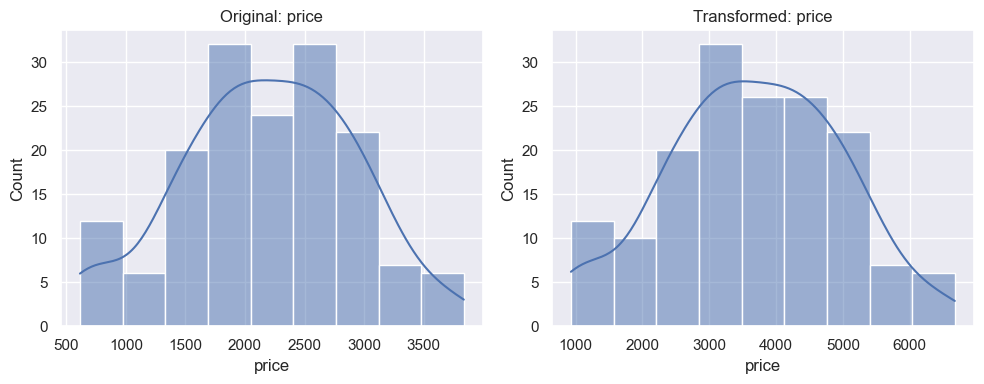

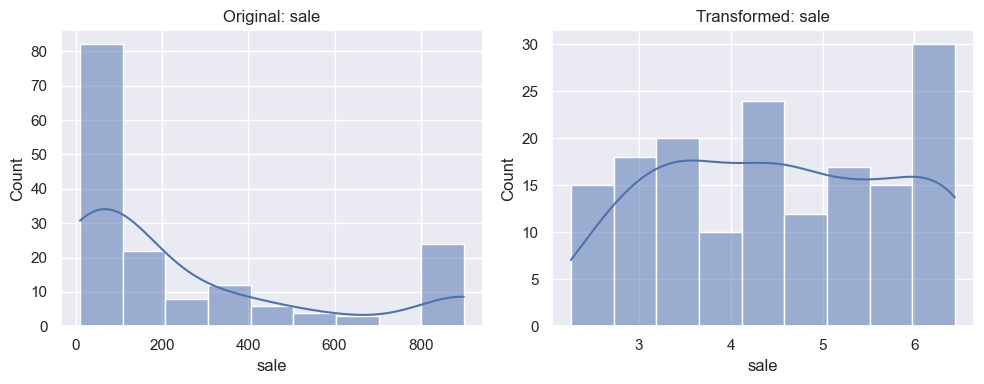

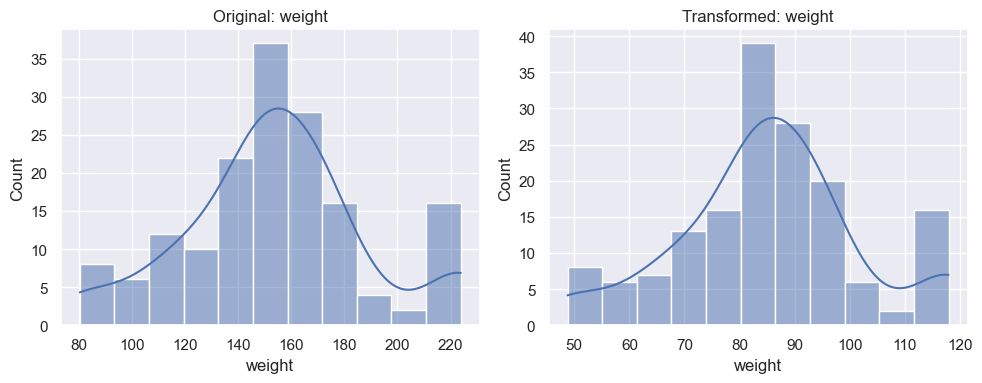

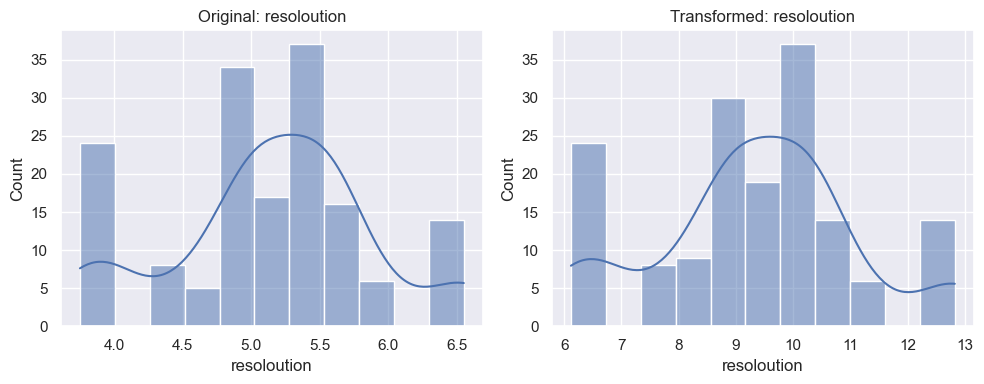

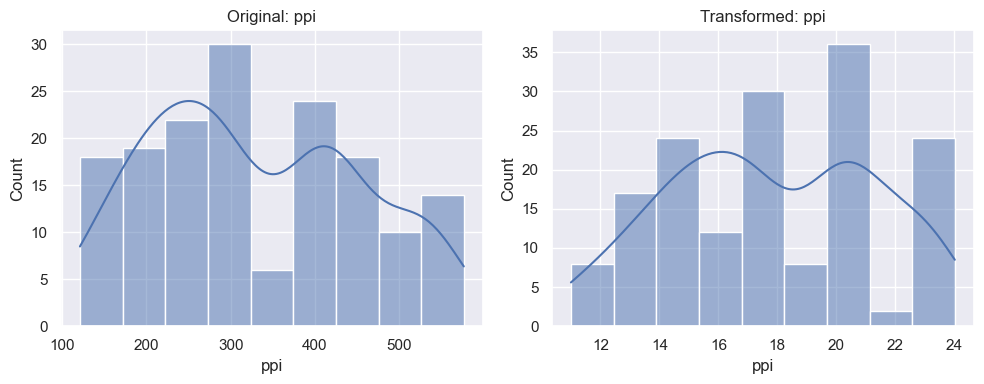

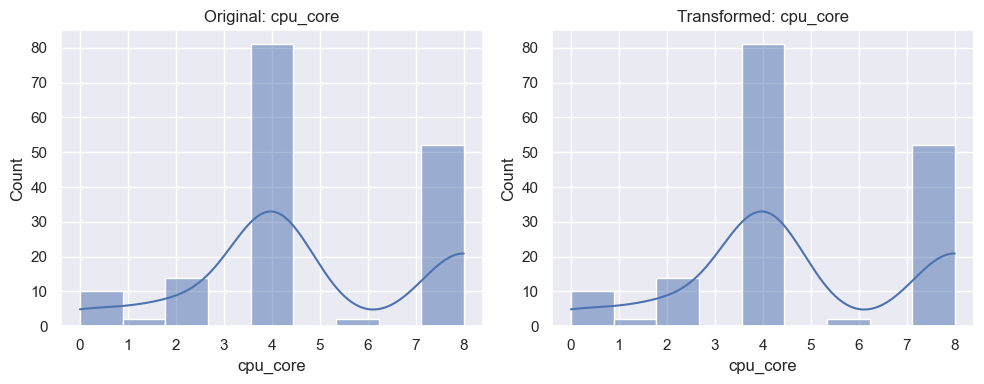

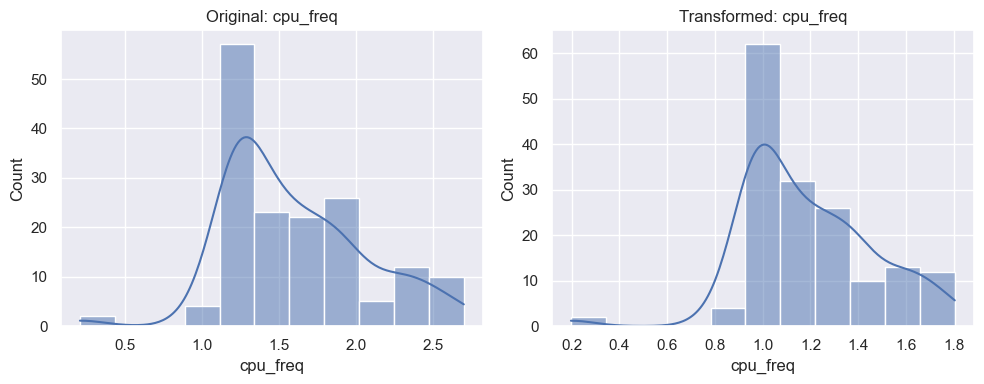

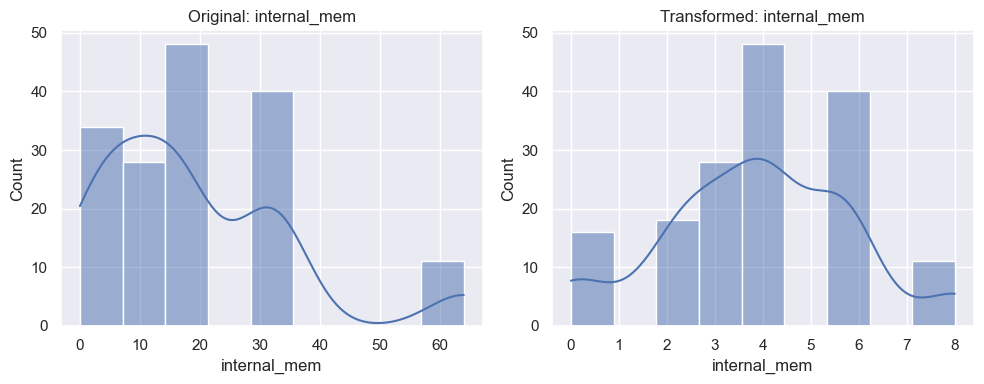

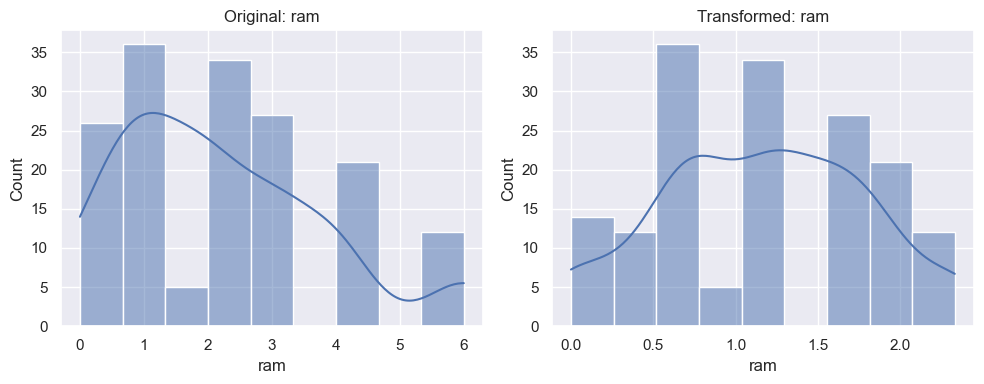

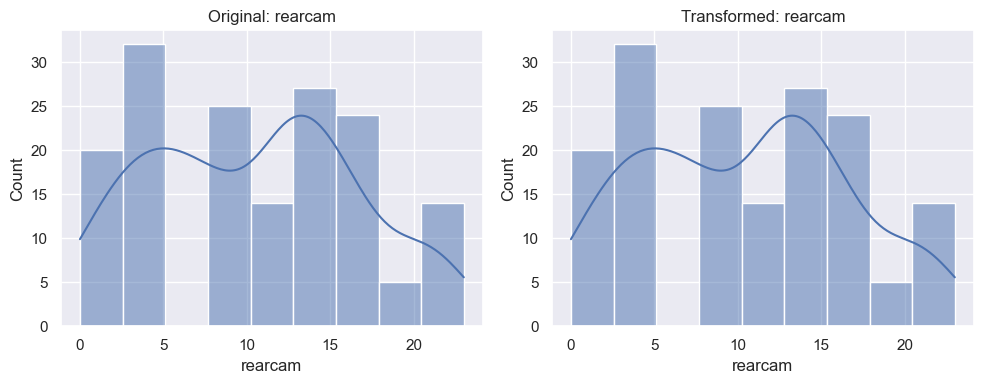

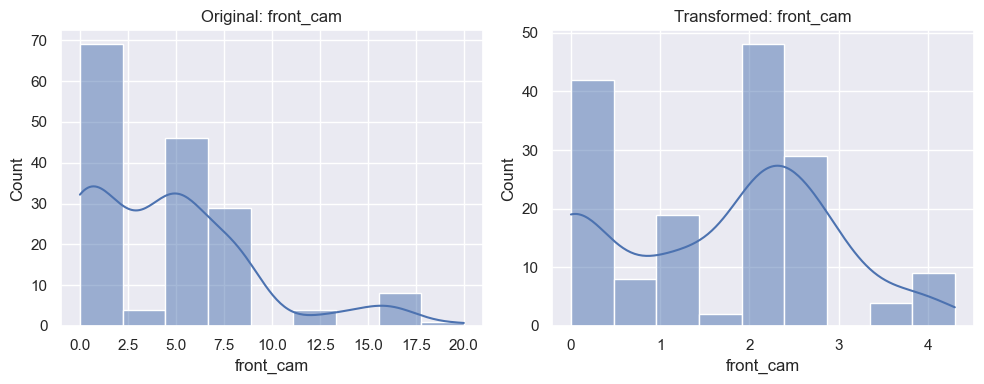

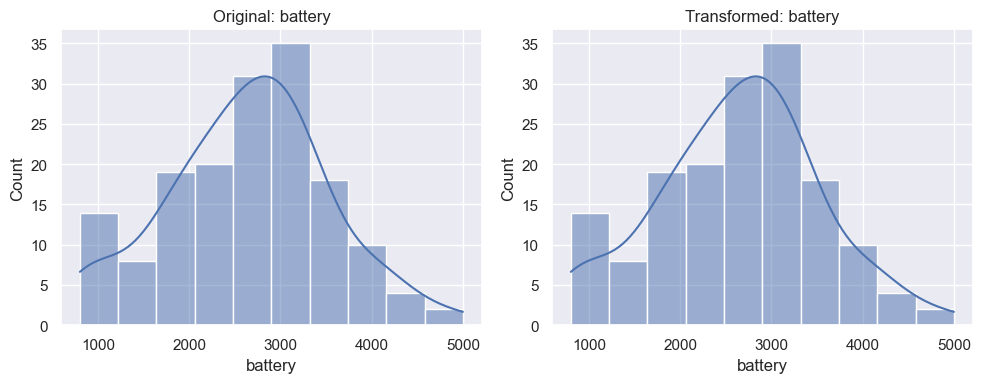

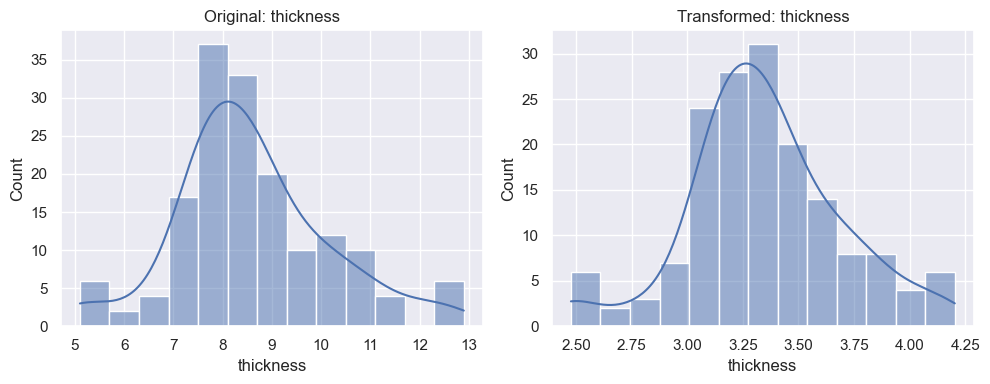

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_distributions(df_original, df_transformed, columns):
    for col in columns:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(df_original[col], kde=True)
        plt.title(f"Original: {col}")

        plt.subplot(1,2,2)
        sns.histplot(df_transformed[col], kde=True)
        plt.title(f"Transformed: {col}")
        plt.tight_layout()
        plt.show()

compare_distributions(mobile, transformed_mobile, mobile.columns)

## Analysis and Visualization of Linear Relation between X and Y

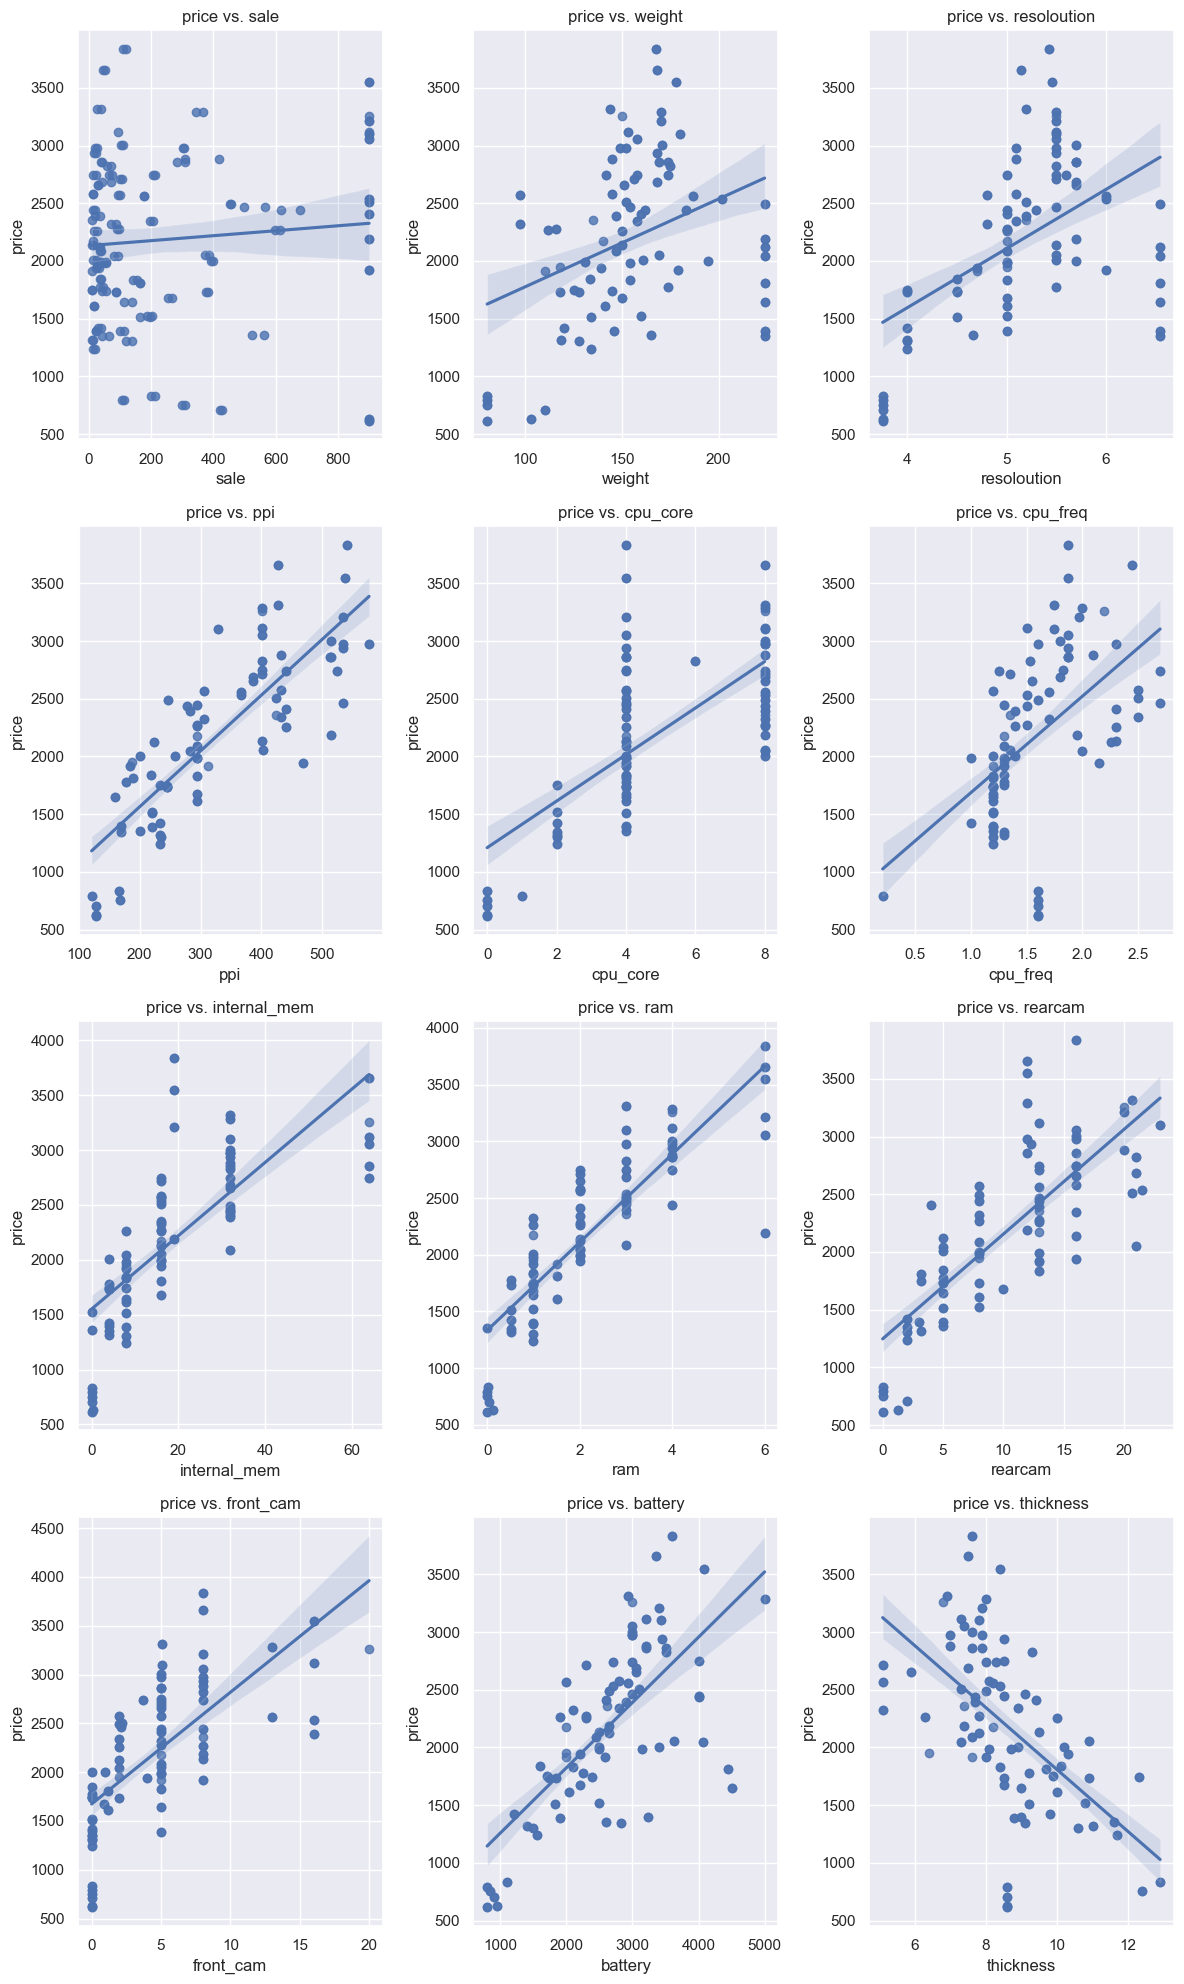

In [62]:
def plot_price_vs_vars(data, cols, target='price', cols_per_row=3):
    rows = (len(cols) + cols_per_row - 1) // cols_per_row  # Ceiling division
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.regplot(x=data[col], y=data[target], ax=axes[i])
        axes[i].set_title(f'{target} vs. {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cols_to_use = [col for col in transformed_mobile.columns if col != "price"]
plot_price_vs_vars(mobile, cols_to_use)

All the X variables have poitive relation with price except thickness.

## Pair Plots all numerical columns on Transformed data


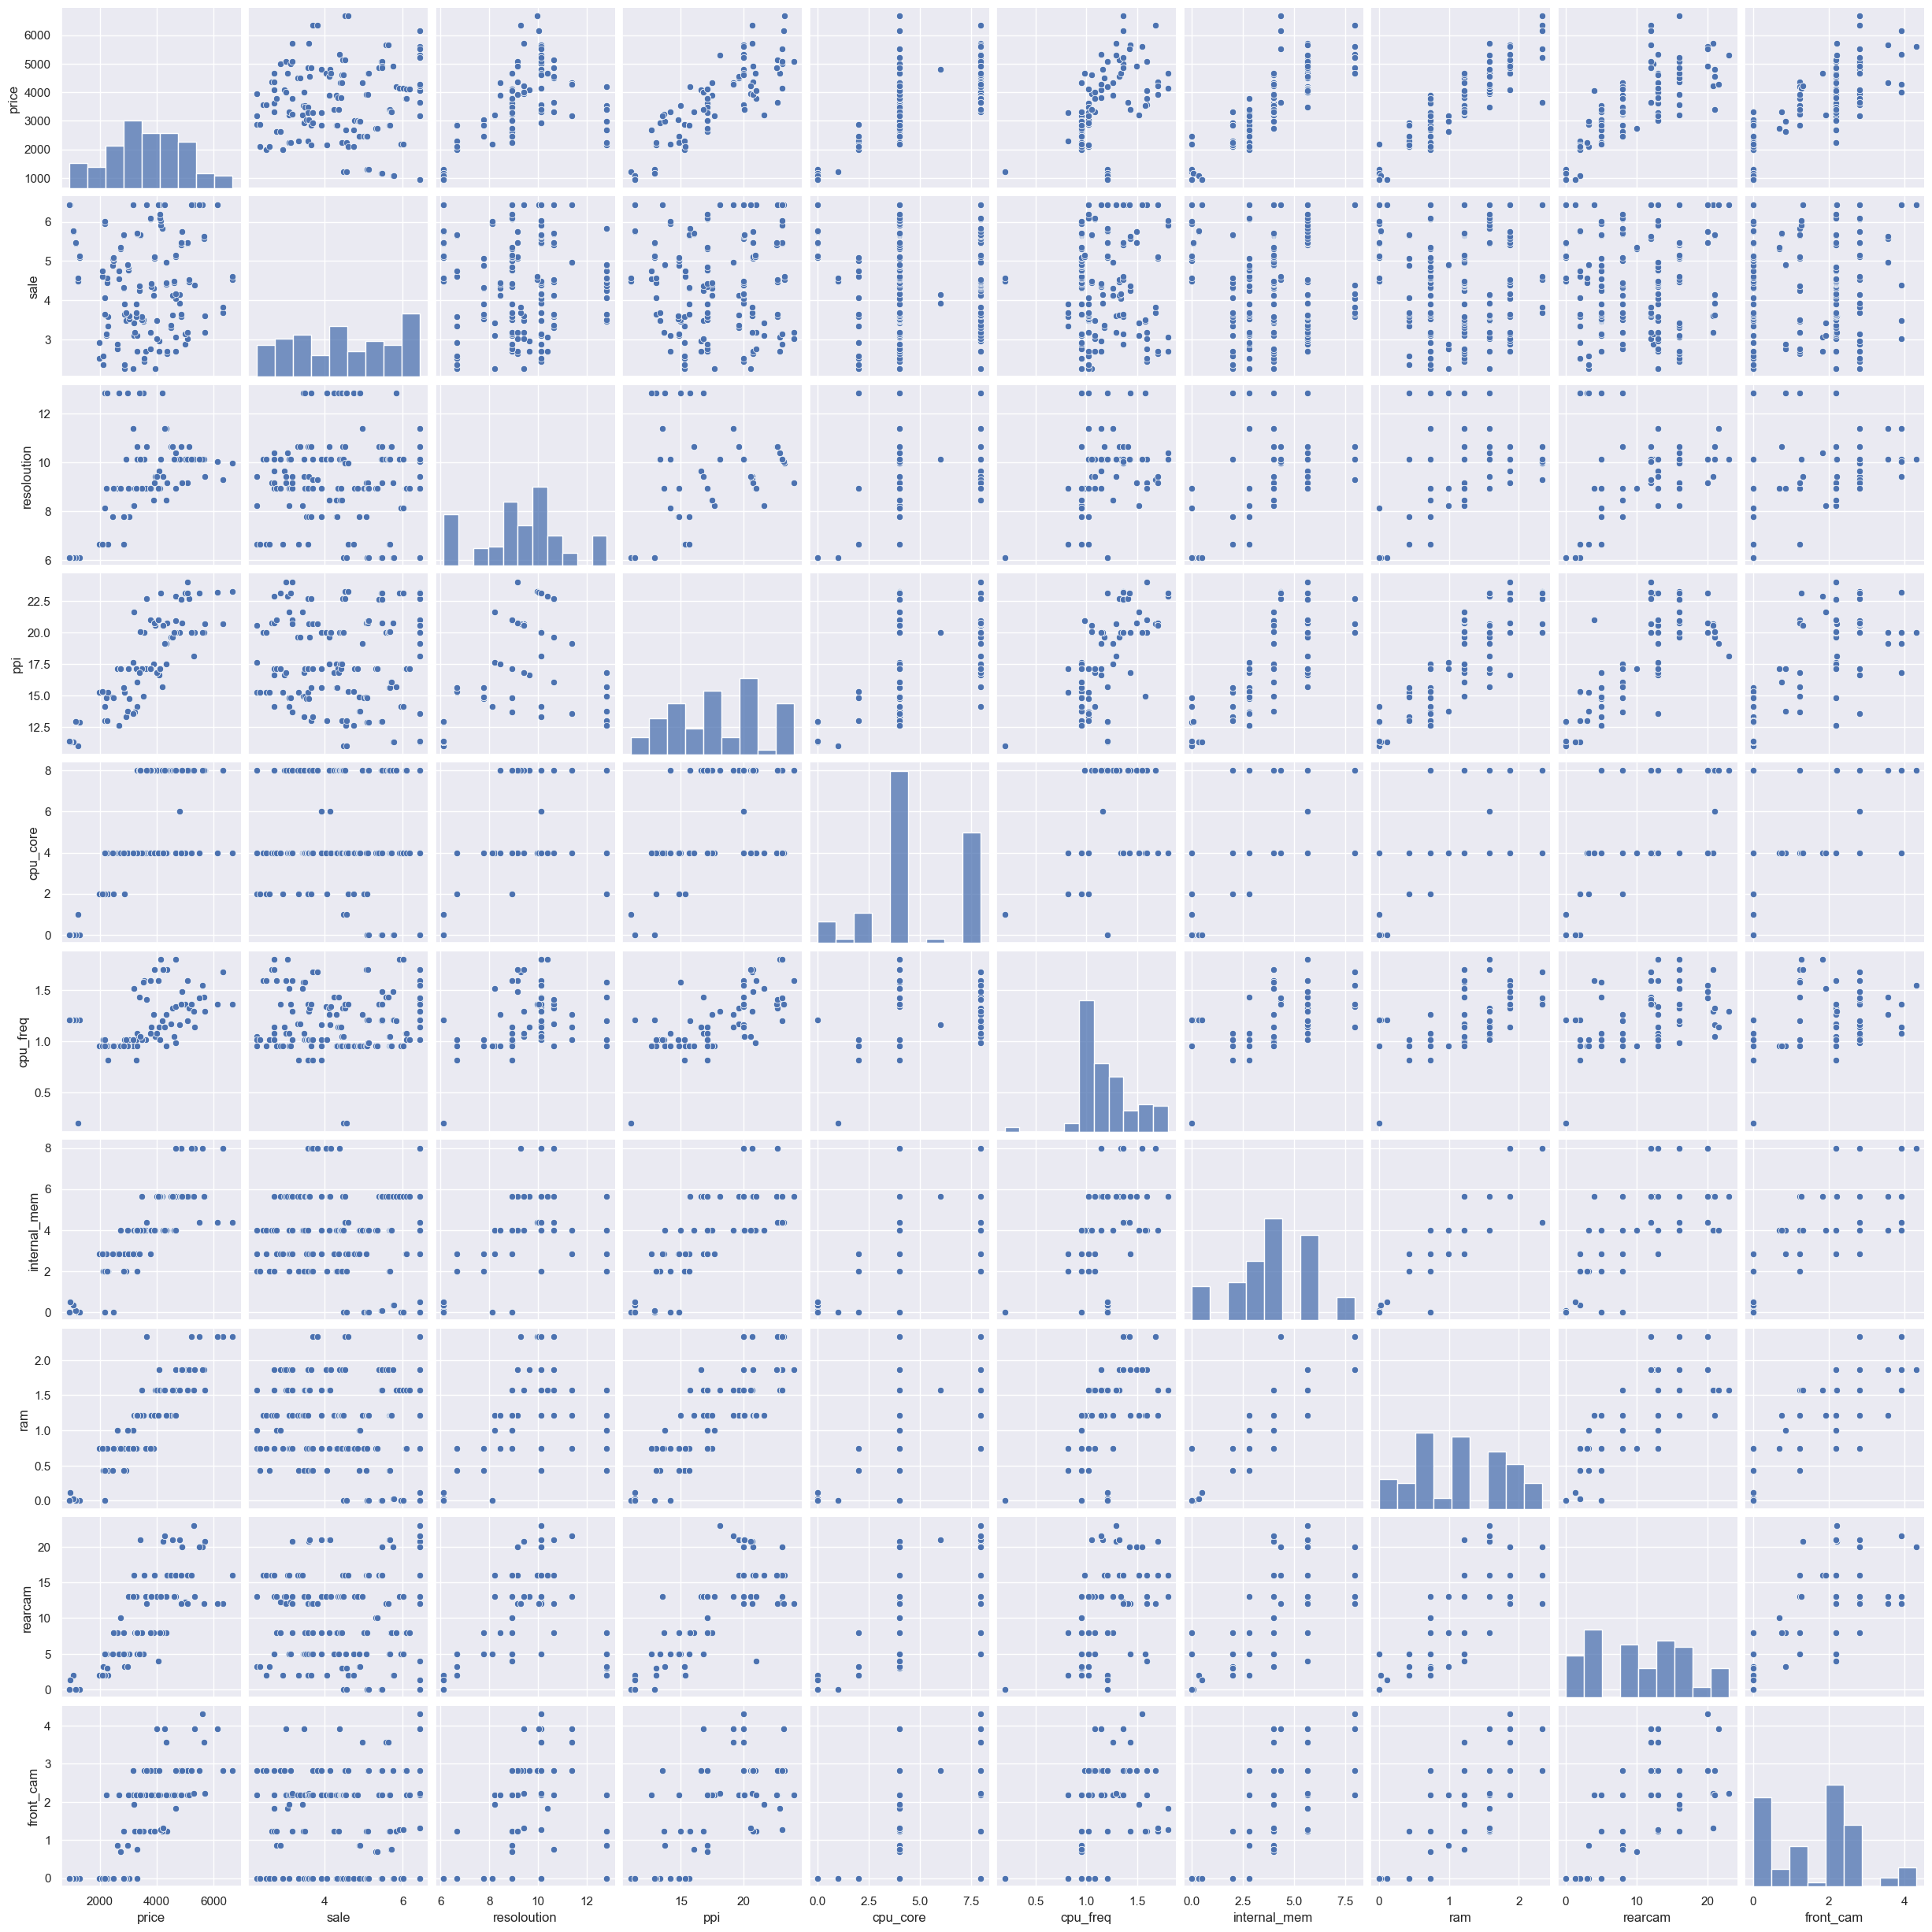

In [63]:
sns.pairplot(transformed_mobile.drop(columns=["battery","thickness","weight"]))
plt.show()

## Checking correlation between features on Transformed Data

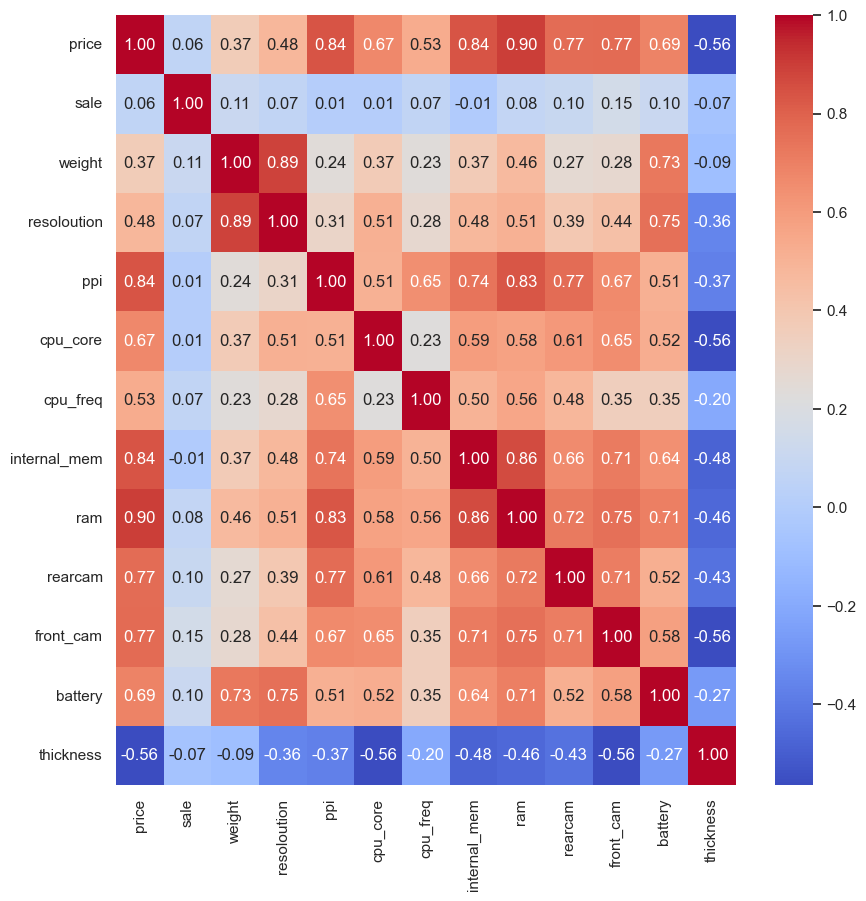

In [64]:
plt.figure(figsize=(10,10))
corr = transformed_mobile.corr()
sns.heatmap(corr,cmap='coolwarm',annot=True,fmt='.2f')
plt.show()

### Feature Distribution (Hist Plot)

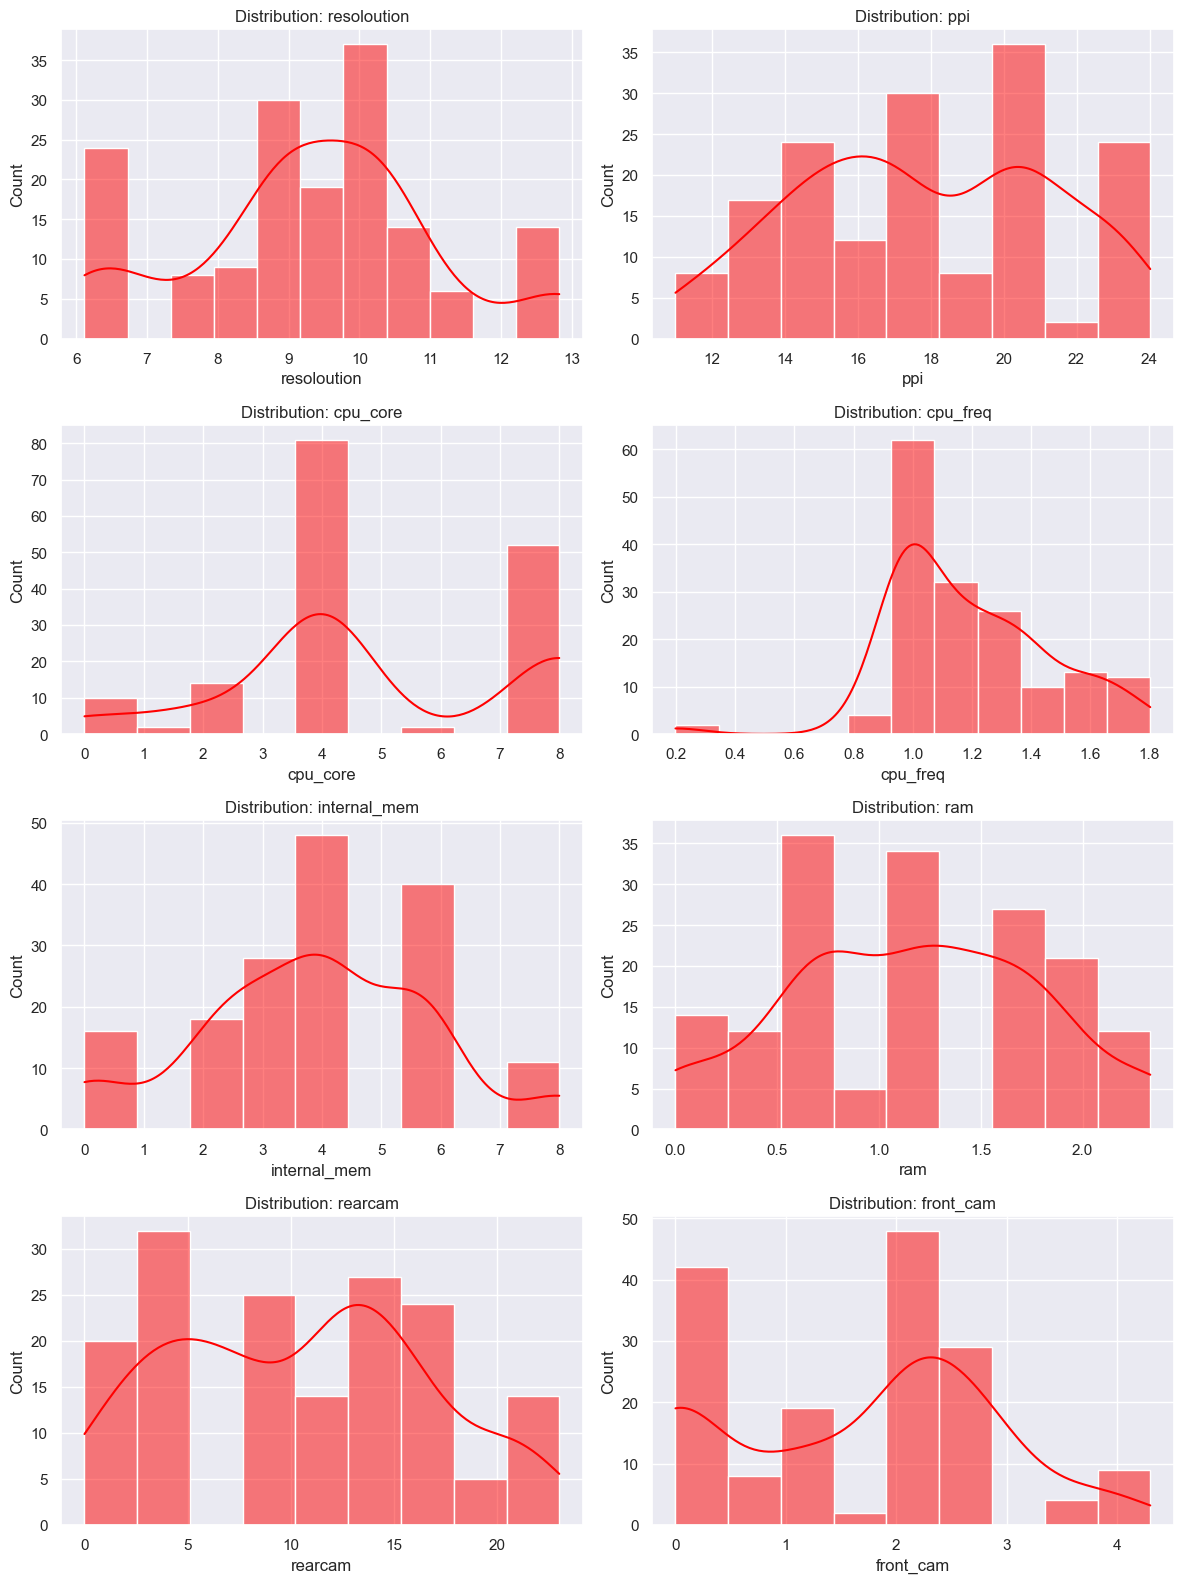

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_distributions(data, columns, charts_per_row=2):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / charts_per_row))

    fig, axes = plt.subplots(num_rows, charts_per_row, figsize=(charts_per_row * 6, num_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(data[col], kde=True, color='red', ax=axes[i])
        axes[i].set_title(f'Distribution: {col}')
    
    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

cols_to_use = [
    col for col in transformed_mobile.columns 
    if col not in ["price", "product_id", "sale", "weight", "battery", "thickness"]
]

plot_distributions(transformed_mobile, cols_to_use, charts_per_row=2)

In [66]:
mobile.shape

(161, 13)

# Common Model Building Function to be called with the ***required*** parameters

In [67]:
def get_transform_info(col):
    try:
        best_transform = skew_summary.loc[skew_summary['Column'] == col, 'Best Transformation'].values[0]
        lambda_val = transform_metadata[col]['lambda']
        return best_transform, lambda_val
    except Exception as e:
        raise KeyError(f"Column '{col}' not found in skew_summary or metadata: {e}")

In [68]:
def detransform(y_transformed, method,param=None):
       
    y_transformed = np.array(y_transformed)

    if method == 'log1p':
        return np.expm1(y_transformed)

    elif method == 'Original':
        return y_transformed

    elif method == 'sqrt':
        return np.square(y_transformed)

    elif method == 'boxcox':
        if param is None:
            raise ValueError("Box-Cox detransformation requires lambda parameter.")
        return inv_boxcox(y_transformed, param)

    elif method == 'yeojohnson':
        if param is None:
            raise ValueError("Yeo-Johnson detransformation requires lambda parameter.")
        #return inv_yeojohnson(y_transformed, param)
        return ((y_transformed * param) + 1) ** (1 / param) - 1

    else:
        raise ValueError(f"Unsupported transformation method: {method}")

## Inverse Transformation

In [69]:
def reversetransformation(df):
    
    #print("here")
    df_transformed = df.copy()
    #display(df)
    #for col in df.columns:
    method, lmbda = get_transform_info(col)
    #print(col,"::",method,":",lmbda)
    df_transformed[col] = detransform(df[col], method, param=lmbda)
    return df_transformed

In [70]:
def reversetransform(df):
    
    #print("here")
    df_transformed = df.copy()
    #display(df)
    for col in df.columns:
        try:
            method, lmbda = get_transform_info(col)
            #print(col,"::",method,":",lmbda)
            df_transformed[col] = detransform(df[col], method, param=lmbda, feat="trans")
        except KeyError:
            print(f"[SKIP] No transformation metadata for column: {col}")
            continue
        except Exception as e:
            print(f"[ERROR] Could not reverse transform {col}: {e}")
            continue
    return df_transformed

In [71]:
  def smape(y_true,y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
      diff = np.abs(y_true - y_pred)    
      nonzero_mask = denominator != 0
      smape_value = np.mean(diff[nonzero_mask] / denominator[nonzero_mask]) * 100    
      return smape_value

In [72]:
def mape(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [ ]:
def predict_comparison(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    plt.figure(figsize=(6, 6))
    plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
    plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    model_name = model.__class__.__name__
    plt.title(f"Actual vs Predicted ({model_name})")    
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [73]:
def model_evaluationbackup(x_train, y_train,x_test, y_test,hyper=None,param=None):
    if x_train is None:
        raise ValueError("The 'x_train' parameter is mandatory and was not provided")
    if y_train is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided")
    if x_validation is None:
        raise ValueError("The 'y_train' parameter is mandatory and was not provided")
    if y_validation is None:
        raise ValueError("The 'y_validation' parameter is mandatory and was not provided")
    if hyper is None:
        raise ValueError("The 'hyper' parameter is mandatory and was not provided. (True = Tuned) with Hyper Parameters")
    if param is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided.scale,trans and both")
       
   # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso L1 Normalization": Lasso(),
        "LassoCV (Cross Validation) ": LassoCV(cv=5),
        "Ridge ": Ridge(),
        "RidgeCV ": RidgeCV(cv=5),
        "ElasticNet": ElasticNet(),
        "ElasticNetCV": ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly"),
        'svr_lin' : SVR(kernel ="linear"),
        'svr_rbf' : SVR(kernel="rbf"),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0)
    }

    models_tuned = {
        'Linear Regression' : LinearRegression(),
        'Lasso L1 Normalization' : Lasso(alpha=0.02310129700083160),#alpha=0.02310129700083160),
        'LassoCV (Cross Validation) ' : LassoCV(cv=5),#alpha=0.02310129700083160),
        'Ridge' : Ridge(alpha=0.02310129700083160),
        'RidgeCV' : RidgeCV(cv=5),
        'ElasticNet' : ElasticNet(alpha=0.0012328467394420659),
        'ElasticNetCV' : ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4),
        'svr_lin' : SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale"),
        'svr_rbf' : SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf"),
        'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators = 400, max_features= "sqrt",min_samples_leaf=5 ,random_state = 1, max_depth = 7),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42),
        'XGBoost' : xgb.XGBRegressor(random_state = 111, max_depth = 3)   
        
    }
    results = []
    
    if hyper == False:
        selected = models        
    elif hyper == True:
        selected = models_tuned
    
    #print("Models Selected::",selected)
    
    for name, model in selected.items():
        model.fit(x_train, y_train)
        y_pred_train = model.predict(x_train)
        y_pred_validation = model.predict(x_test)
        
        if (param == "trans"):
            y_pred_train  = reversetransformation(pd.DataFrame(y_pred_train, columns=['price']))
            y_pred_validation  = reversetransformation(pd.DataFrame(y_pred_validation, columns=['price']))
        elif (param == "scale"):
            y_pred_train  = descale(scale,pd.DataFrame(y_pred_train))
            y_pred_validation  = descale(scale,pd.DataFrame(y_pred_validation))
        elif (param == "both"):
            y_pred_train  = reversetransformation(descale(scale,pd.DataFrame(y_pred_train, columns=['price'])))
            y_pred_validation  = reversetransformation(descale(scale,pd.DataFrame(y_pred_validation, columns=['price'])))
        else:
            y_pred_train = model.predict(x_train)
            y_pred_validation = model.predict(x_test)
        
        predict_comparison(model)    
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_validation))
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_validation)
        
        n_train, p_train = x_train.shape
        n_test, p_test = x_test.shape
        train_adj_r2 = 100 * (1 - (1 - r2_score(y_train, y_pred_train) / 100) * (n_train - 1) / (n_train - p_train - 1))
        test_adj_r2 = 100 * (1 - (1 - r2_score(y_test, y_pred_validation) / 100) * (n_test - 1) / (n_test - p_test))
        
        overfitting = "Y" if train_r2 - test_r2 > 0.1 else "N"
        
        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_validation),
            
            "Train MSE": mean_squared_error(y_train, y_pred_train),
            "Test MSE": mean_squared_error(y_test, y_pred_validation),
            
            "Train SMAPE": smape(y_train,y_pred_train),
            "Test SMAPE_test Erro": smape(y_test,y_pred_validation),
            
            "Train MAPE_Train Error:": mape(y_train,y_pred_train),
            "Test MAPE_test Error": mape(y_test,y_pred_validation),
            
            "Train RMSE": round(train_rmse, 4),
            "Test RMSE": round(test_rmse, 4),
            
            "Train R²": round(train_r2, 4),
            "Test R²": round(test_r2, 4),
            
            "Train Adjusted R2":round(train_adj_r2,2),
            "Test Adjusted R2":test_adj_r2,
            
            "Overfitting (Y/N)": overfitting
        })
    
    comparison_df = pd.DataFrame(results)
    ordered_columns = ['Model', 'Train MAE','Test MAE','Train MSE','Test MSE','Train RMSE', 'Test RMSE',
                       'Train R²', 'Test R²','Train Adjusted R2','Test Adjusted R2' ,'Overfitting (Y/N)']
    
    comparison_raw = comparison_df[ordered_columns]
    #return comparison_raw

    #####comparison_raw =  model_evaluation(mobile,"price",raw=True)
    display(comparison_raw)

    filtered = comparison_raw[comparison_raw['Overfitting (Y/N)'] == 'N']

    filtered = filtered.copy()
    filtered['Score'] = filtered['Test R²'] - (filtered['Test RMSE'] / filtered['Test RMSE'].max())

    # Get the best model
    best_model_row = filtered.loc[filtered['Score'].idxmax()]
    best_model_name = best_model_row['Model']

    print("Best Model Based on Score:")
    display(pd.DataFrame(best_model_row[['Model', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²']])) 

In [74]:
def model_evaluation(x_train, y_train,x_test, y_test,hyper=None,param=None,handle=None):
    y = pd.DataFrame()
    #print("y_test before inverse is:",y_test)
    if x_train is None:
        raise ValueError("The 'x_train' parameter is mandatory and was not provided")
    if y_train is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided")
    if x_test is None:
        raise ValueError("The 'y_train' parameter is mandatory and was not provided")
    if y_test is None:
        raise ValueError("The 'y_validation' parameter is mandatory and was not provided")
    if hyper is None:
        raise ValueError("The 'hyper' parameter is mandatory and was not provided. (True = Tuned) with Hyper Parameters")
    if param is None:
        raise ValueError("The 'param' parameter is mandatory and was not provided.scale,trans and both")
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory and is the same scalsr handle used for scaling")
       
   # Define models
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso L1 Normalization": Lasso(),
        "LassoCV (Cross Validation) ": LassoCV(cv=5),
        "Ridge ": Ridge(),
        "RidgeCV ": RidgeCV(cv=5),
        "ElasticNet": ElasticNet(),
        "ElasticNetCV": ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly"),
        'svr_lin' : SVR(kernel ="linear"),
        'svr_rbf' : SVR(kernel="rbf"),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0),
        "lgbm": LGBMRegressor(verbose=-1),
        "catboost": CatBoostRegressor(verbose=False),
        "adaboost": AdaBoostRegressor(),
        "voting Regresor": VotingRegressor(
            estimators=[('lr', LinearRegression()),('rf', RandomForestRegressor(n_estimators=100, random_state=42)),('knn', KNeighborsRegressor())]),
        "Bagging Regressor": BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),n_estimators=50, max_samples=0.8,max_features=0.8,random_state=42,n_jobs=-1 ),

    }

    models_tuned = {
        'Linear Regression' : LinearRegression(),
        'Lasso L1 Normalization' : Lasso(alpha=0.02310129700083160),#alpha=0.02310129700083160),
        'LassoCV (Cross Validation) ' : LassoCV(cv=5),#alpha=0.02310129700083160),
        'Ridge' : Ridge(alpha=0.02310129700083160),
        'RidgeCV' : RidgeCV(cv=5),
        'ElasticNet' : ElasticNet(alpha=0.0012328467394420659),
        'ElasticNetCV' : ElasticNetCV(cv=5),
        'svr_poly': SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4),
        'svr_lin' : SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale"),
        'svr_rbf' : SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf"),
        'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
        'Random Forest': RandomForestRegressor(n_estimators = 400, max_features= "sqrt",min_samples_leaf=5 ,random_state = 1, max_depth = 7),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42),
        'XGBoost' : xgb.XGBRegressor(random_state = 111, max_depth = 3)   
        
    }
    results = []
    
    if hyper == False:
        selected = models        
    elif hyper == True:
        selected = models_tuned
    
    #print("Models Selected::",selected)
    
    for name, model in selected.items():
        model.fit(x_train, y_train)       
        
        
        if (param == "trans"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            y_pred_train  = reversetransformation(pd.DataFrame(y_pred_t, columns=['price']))
            y_pred_validation  = reversetransformation(pd.DataFrame(y_pred_v, columns=['price']))

            y_train  = reversetransformation(pd.DataFrame(y_train, columns=['price']))
            y_test  = reversetransformation(pd.DataFrame(y_test, columns=['price']))

            #print("y_pred after processing is:\n",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)

        elif (param == "scale"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            y_pred_train  = descale(scale,pd.DataFrame(y_pred_t))
            y_pred_validation  = descale(scale,pd.DataFrame(y_pred_v))

            y_train  = descale(scale,pd.DataFrame(y_train,columns=['price']))
            y_test  = descale(scale,pd.DataFrame(y_test,columns=['price']))

            #print("y_pred after processing is:\n",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)
            
            
        elif (param == "both"):
            y_pred_t = model.predict(x_train)
            y_pred_v = model.predict(x_test)
            
            y_pred_train  = reversetransformation(descale(scale,pd.DataFrame(y_pred_t, columns=['price'])))
            y_pred_validation  = reversetransformation(descale(scale,pd.DataFrame(y_pred_v, columns=['price'])))

            y_train  = reversetransformation(descale(scale,pd.DataFrame(y_train, columns=['price'])))
            y_test  = reversetransformation(descale(scale,pd.DataFrame(y_test, columns=['price'])))

            #print("y_pred after processing is\n:",y_pred_validation,"\n")
            #print("y_test after processing :", y_test)
            
        else:                        
            y_pred_train = model.predict(x_train)
            y_pred_validation = model.predict(x_test)
            
            #print("y_pred is:\n",y_pred_validation,"\n")
            #print("y_test :", y_test)
            
        #print("Predicted Descale and detranaform",y_pred_train,"\n")
        #print("Scaled, transformed,",y_train)
        
        
        train_rmse = np.sqrt(mean_squared_error(y_train , y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_validation))
        
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_validation)
        
        n_train, p_train = x_train.shape
        n_test, p_test = x_test.shape
        train_adj_r2 = 100 * (1 - (1 - r2_score(y_train, y_pred_train) / 100) * (n_train - 1) / (n_train - p_train - 1))
        test_adj_r2 = 100 * (1 - (1 - r2_score(y_test, y_pred_validation) / 100) * (n_test - 1) / (n_test - p_test))
        
        overfitting = "Y" if train_r2 - test_r2 > 0.1 else "N"
        
        results.append({
            "Model": name,
            "Train MAE": mean_absolute_error(y_train, y_pred_train),
            "Test MAE": mean_absolute_error(y_test, y_pred_validation),
            
            "Train MSE": mean_squared_error(y_train, y_pred_train),
            "Test MSE": mean_squared_error(y_test, y_pred_validation),
            
            "Train SMAPE": smape(y_train,y_pred_train),
            "Test SMAPE_test Erro": smape(y_test,y_pred_validation),
            
            "Train MAPE_Train Error:": mape(y_train,y_pred_train),
            "Test MAPE_test Error": mape(y_test,y_pred_validation),
            
            "Train RMSE": round(train_rmse, 4),
            "Test RMSE": round(test_rmse, 4),
            
            "Train R²": round(train_r2, 4),
            "Test R²": round(test_r2, 4),
            
            "Train Adjusted R2":round(train_adj_r2,2),
            "Test Adjusted R2":test_adj_r2,
            
            "Overfitting (Y/N)": overfitting
        })
    
    comparison_df = pd.DataFrame(results)
    ordered_columns = ['Model', 'Train MAE','Test MAE','Train MSE','Test MSE','Train RMSE', 'Test RMSE',
                       'Train R²', 'Test R²','Train Adjusted R2','Test Adjusted R2' ,'Overfitting (Y/N)']
    
    comparison_raw = comparison_df[ordered_columns]
    #return comparison_raw

    #####comparison_raw =  model_evaluation(mobile,"price",raw=True)
    display(comparison_raw)

    filtered = comparison_raw[comparison_raw['Overfitting (Y/N)'] == 'N']

    filtered = filtered.copy()
    filtered['Score'] = filtered['Test R²'] - (filtered['Test RMSE'] / filtered['Test RMSE'].max())

    # Get the best model
    best_model_row = filtered.loc[filtered['Score'].idxmax()]
    best_model_name = best_model_row['Model']

    print("Best Model Based on Score:")
    display(pd.DataFrame(best_model_row[['Model', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²']])) 
    #print(y)      


# Inverse Scaling

In [ ]:
#New 
def scale_descale_columns(scale,df, columns_to_scale,param=None):
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory.This should be the same instace of scaling method)")
    if scaled_data is None:
        raise ValueError("The 'scaled_data' parameter is mandatory.This should be the scaled data)")  
        
    if (param == "scale")        
        df_scaled = df.copy()
        df_scaled[columns_to_scale] = scaler.fit_transform(df_scaled[columns_to_scale])
        return df_scaled, scaler
    elif(param == "descale")
        scaled_df, scaler = standard_scale_columns(df, columns_to_scale)

In [75]:
def descale(handle,scaled_data):
    if handle is None:
        raise ValueError("The 'handle' parameter is mandatory.This should be the same instace of scaling method)")
    if scaled_data is None:
        raise ValueError("The 'scaled_data' parameter is mandatory.This should be the scaled data)")    
        
    original = handle.inverse_transform(scaled_data)
    original_df = pd.DataFrame(original, columns=scaled_data.columns,index=scaled_data.index)    
    return original_df

# Split and Scale 

In [76]:
def split_scale(scale_handle,df,target_col,scale=False):
    if scale == True:
        if scale_handle is None:
            raise ValueError("The 'scale handle' parameter is mandatory as scaling is True)")
            
    if df is None:
        raise ValueError("The 'df' parameter is mandatory.This should be the dataFrame)")
    if target_col is None:
        raise ValueError("The 'target_col' parameter is mandatory.This should be the target Variable)")     
 
    
    train, validation = train_test_split(df,train_size=0.75, random_state=1)    
    x_train = train.drop([target_col],axis=1)
    y_train =pd.DataFrame(train[target_col])
    
    x_validation = validation.drop([target_col],axis=1)
    y_validation = pd.DataFrame(validation[target_col])
    if (scale == True):
        x_train = pd.DataFrame(scale_handle.fit_transform(x_train), columns=x_train.columns, index=x_train.index)
        y_train = pd.DataFrame(scale_handle.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
        x_validation = pd.DataFrame(scale_handle.fit_transform(x_validation), columns=x_validation.columns, index=x_validation.index)
        y_validation = pd.DataFrame(scale_handle.fit_transform(y_validation), columns=y_validation.columns, index=y_validation.index)
    return x_train,y_train,x_validation,y_validation

# Model Building on Raw/Untreated Data

In [79]:
x_train, y_train,x_test, y_test = split_scale(scale_handle=None,df=mobile,target_col="price",scale=False)
model_evaluation(x_train, y_train,x_test, y_test,hyper=False,param="raw",handle=scale)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 222
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 12
[LightGBM] [Info] Start training from score 2222.626835
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Model   Train MAE    Test MAE      Train MSE  \
0             Linear Regression  188.807600  156.812411   58844.107324   
1        Lasso L1 Normalization  188.202921  154.947714   58879.329304   
2   LassoCV (Cross Validation)   255.298376  274.864072   95479.152246   
3                        Ridge   188.514103  156.212532   58851.065150   
4                      RidgeCV   187.744357  155.288163   59088.500848   
5                    ElasticNet  190.386762  162.964816   60998.080538   
6                  ElasticNetCV  266.102372  297.468803  105493.247283   
7                      svr_poly  558.173242  597.667220  483439.665177   
8                       svr_lin  191.811972  175.759870   72493.050558   
9                       svr_rbf  584.863095  599.540061  521861.049526   
10                Decision Tree    0.000000   40.146341       0.000000   
11                Random Forest   47.573942   81.325461    4514.987408   
12            Gradient Boosting   25.154137   47.346998     981.628496   
13                      XGBoost    0.000956   34.381791       0.000002   
14                         lgbm   81.176218  121.134168   12868.927824   
15                     catboost    4.915572   33.512678      37.993968   
16                     adaboost  117.332019  115.719222   19670.980019   
17              voting Regresor  132.316296  176.763331   29613.184092   
18            Bagging Regressor   62.152161   83.027995    7078.900308   

         Test MSE  Train RMSE  Test RMSE  Train R²  Test R²  \
0    37211.360948    242.5780   192.9025    0.8890   0.9271   
1    36274.843901    242.6506   190.4596    0.8889   0.9290   
2   102233.067114    308.9970   319.7391    0.8199   0.7998   
3    36898.477991    242.5924   192.0898    0.8890   0.9277   
4    36434.994065    243.0813   190.8795    0.8885   0.9286   
5    39775.497371    246.9779   199.4380    0.8849   0.9221   
6   126098.067191    324.7972   355.1029    0.8010   0.7530   
7   529985.723400    695.2983   728.0012    0.0881  -0.0380   
8    52617.039300    269.2453   229.3840    0.8633   0.8969   
9   538454.632504    722.3995   733.7947    0.0156  -0.0546   
10   13042.146341      0.0000   114.2022    1.0000   0.9745   
11   10628.607863     67.1937   103.0951    0.9915   0.9792   
12    3681.185277     31.3310    60.6728    0.9981   0.9928   
13    5679.269705      0.0015    75.3609    1.0000   0.9889   
14   26531.620414    113.4413   162.8853    0.9757   0.9480   
15    3473.424867      6.1639    58.9358    0.9999   0.9932   
16   22064.830644    140.2533   148.5424    0.9629   0.9568   
17   51511.533261    172.0848   226.9615    0.9441   0.8991   
18   13089.573605     84.1362   114.4097    0.9866   0.9744   

    Train Adjusted R2  Test Adjusted R2 Overfitting (Y/N)  
0              -10.23        -36.652249                 N  
1              -10.23        -36.649719                 N  
2              -10.30        -36.827902                 N  
3              -10.23        -36.651404                 N  
4              -10.23        -36.650152                 N  
5              -10.23        -36.659176                 N  
6              -10.32        -36.892372                 N  
7              -11.12        -37.983456                 Y  
8              -10.25        -36.693867                 N  
9              -11.20        -38.006334                 N  
10             -10.10        -36.586957                 N  
11             -10.11        -36.580437                 N  
12             -10.10        -36.561669                 N  
13             -10.10        -36.567066                 N  
14             -10.13        -36.623398                 N  
15             -10.10        -36.561107                 N  
16             -10.14        -36.611331                 N  
17             -10.16        -36.690880                 N  
18             -10.12        -36.587085                 N

Best Model Based on Score:


15
Model       catboost
Train RMSE    6.1639
Test RMSE    58.9358
Train R²      0.9999
Test R²       0.9932

# Model Building on Transformed Data

In [ ]:
x_train, y_train,x_test, y_test = split_scale(scale_handle=None,df=transformed_mobile,target_col="price",scale=False)
model_evaluation(x_train, y_train,x_test, y_test,hyper=False,param="trans",handle=scale)

# Model Building on Transformed and Scaled Data

## Part III -Scaling the data

| Transformer Class      | What `transform()` Does                                           | Purpose                         |
| ---------------------- | ----------------------------------------------------------------- | ------------------------------- |
| `StandardScaler()`     | Subtracts mean, divides by std (z-score)                          | Standardization (mean=0, std=1) |
| `MinMaxScaler()`       | Scales to a fixed range (default \[0, 1])                         | Normalization                   |
| `RobustScaler()`       | Scales using median and IQR (less sensitive to outliers)          | Robust normalization            |
| `PowerTransformer()`   | Applies **Yeo-Johnson** or **Box-Cox** for variance stabilization | Make data more Gaussian         |
| `OneHotEncoder()`      | Converts categorical variables to binary (0/1) columns            | Categorical encoding            |
| `LabelEncoder()`       | Converts categories to integers (e.g., A=0, B=1)                  | Label encoding                  |
| `PCA()`                | Projects data onto principal components (linear combinations)     | Dimensionality reduction        |
| `SimpleImputer()`      | Fills missing values with mean/median/mode                        | Handling missing data           |
| `PolynomialFeatures()` | Expands features to include polynomial terms                      | Feature expansion               |


In [83]:
mobile

price   sale  weight  resoloution    ppi  cpu_core  cpu_freq  \
0    2357.0   10.0   135.0         5.20  424.0         8     1.350   
1    1749.0   10.0   125.0         4.00  233.0         2     1.300   
2    1916.0   10.0   110.0         4.70  312.0         4     1.200   
3    1315.0   11.0   118.5         4.00  233.0         2     1.300   
4    1749.0   11.0   125.0         4.00  233.0         2     1.300   
..      ...    ...     ...          ...    ...       ...       ...   
156  3551.0  899.5   178.0         5.46  538.0         4     1.875   
157  3211.0  899.5   170.0         5.50  534.0         4     1.975   
158  3260.0  899.5   150.0         5.50  401.0         8     2.200   
159  3211.0  899.5   170.0         5.50  534.0         4     1.975   
160  2536.0  899.5   202.0         6.00  367.0         8     1.500   

     internal_mem    ram  rearcam  front_cam  battery  thickness  
0       16.000000  3.000    13.00        8.0   2610.0        7.4  
1        4.000000  1.000     3.15        0.0   1700.0        9.9  
2        8.000000  1.500    13.00        5.0   2000.0        7.6  
3        4.000000  0.512     3.15        0.0   1400.0       11.0  
4        4.000000  1.000     3.15        0.0   1700.0        9.9  
..            ...    ...      ...        ...      ...        ...  
156     19.090039  6.000    12.00       16.0   4080.0        8.4  
157     19.090039  6.000    20.00        8.0   3400.0        7.9  
158     64.000000  4.000    20.00       20.0   3000.0        6.8  
159     19.090039  6.000    20.00        8.0   3400.0        7.9  
160     16.000000  3.000    21.50       16.0   2700.0        8.4  

[161 rows x 13 columns]

## Choose Scaling Method

In [78]:
#scale = RobustScaler()
#scale = MinMaxScaler()
scale = StandardScaler()
#scale = PowerTransformer()

## Select the Data to Model (Raw, Transformed Only, Transformed + Scaled)

#### ***Transformed  - > Option#1***
#### ***Transformed - > Option#2***
#### ***Raw - > Option#3***

In [2]:
def select_data(param=None):
    if(param == 1):
        print("You have selected Tranaformed Data")
        return transformed_mobile
    if(param == 2):
        print("You have selected Outlier Treated Data")
        return mobile_iqr
    if(param == 3):
        print("You have selected raw Data")
        return mobile        

## Select Data Frame for Model Evaluation

In [5]:
inpu = input("Enter the Value: \n 1: For Transformed Data \n 2: for Outlier Treated Data\n 3: for raw Data\n")
scaled_mobile = select_data(int(inpu))

Enter the Value: 
 1: For Transformed Data 
 2: for Outlier Treated Data
 3: for raw Data
 1


You have selected Tranaformed Data


NameError: name 'transformed_mobile' is not defined

# Model Building on Scaled + Transformed Data

In [92]:
x_train, y_train,x_test, y_test = split_scale(scale_handle=scale,df=scaled_mobile,target_col="price",scale=True)
model_evaluation(x_train, y_train,x_test, y_test,hyper=False,param="both",handle=scale)

y_test before inverse is:         price
44   1.079965
47   1.740145
110 -1.826946
77  -0.971753
158  1.658855
11  -0.129807
116  1.698035
35   0.786347
145 -0.248457
14   0.680774
78   0.872112
99  -0.814852
91  -0.373652
19  -1.185708
138  0.437704
75   0.249549
107 -0.588159
81  -1.778828
85  -0.971753
159  1.587813
102 -0.799795
29  -0.208020
39   0.413609
123 -0.136797
95  -0.402798
54  -0.160554
5    0.053797
141 -1.989411
92  -0.373652
16   0.224147
31   1.249708
53   2.238800
40   0.035537
93  -0.402798
100  0.344232
42  -0.356986
132  0.518586
51  -1.038313
89  -1.099278
154  0.618110
84  -0.629507
y_pred_validation after processing is:           price
0   3047.724095
1   2881.557323
2    692.639228
3   1611.420638
4   3049.935342
5   1719.592691
6   3177.079557
7   2757.395611
8   1751.190026
9   2425.759090
10  2635.042972
11  1496.930107
12  1855.905818
13  1338.079277
14  2313.123422
15  2337.977881
16  1923.023380
17   891.962578
18  1612.974507
19  3180.332830
20  1486.27

Model     Train MAE      Test MAE     Train MSE  \
0             Linear Regression  1.866552e+02  1.476404e+02  5.766944e+04   
1        Lasso L1 Normalization  8.323556e+04  6.526638e+04  1.136842e+10   
2   LassoCV (Cross Validation)   2.424389e+07  1.939211e+07  9.910283e+14   
3                        Ridge   4.661992e+09  3.626567e+09  3.481451e+19   
4                      RidgeCV   6.183787e+11  4.789499e+11  6.251921e+23   
5                    ElasticNet  6.125695e+13  5.002731e+13  6.333398e+27   
6                  ElasticNetCV  1.239135e+16  1.187192e+16  2.408527e+32   
7                      svr_poly  6.141522e+17  5.992238e+17  6.173729e+35   
8                       svr_lin  2.315712e+19  2.255288e+19  8.868921e+38   
9                       svr_rbf  6.724459e+20  6.537589e+20  7.554788e+41   
10                Decision Tree  0.000000e+00  5.806398e+21  0.000000e+00   
11                Random Forest  2.228830e+22  7.694337e+22  8.729416e+44   
12            Gradient Boosting  1.668393e+23  1.196648e+24  4.265689e+46   
13                      XGBoost  5.048087e+25  4.725555e+25  4.168152e+51   

        Test MSE    Train RMSE     Test RMSE  Train R²  Test R²  \
0   3.450631e+04  2.401446e+02  1.857588e+02    0.8883   0.9324   
1   6.606738e+09  1.066228e+05  8.128184e+04    0.8912   0.9354   
2   5.962195e+14  3.148060e+07  2.441761e+07    0.8880   0.9304   
3   2.015930e+19  5.900382e+09  4.489911e+09    0.8957   0.9370   
4   3.451050e+23  7.906909e+11  5.874564e+11    0.8945   0.9387   
5   3.891002e+27  7.958265e+13  6.237789e+13    0.8789   0.9209   
6   2.245025e+32  1.551943e+16  1.498341e+16   -0.0001  -0.0000   
7   5.704177e+35  7.857308e+17  7.552600e+17   -0.0192  -0.0187   
8   8.129511e+38  2.978073e+19  2.851230e+19   -0.0213  -0.0207   
9   6.872964e+41  8.691828e+20  8.290334e+20   -0.0233  -0.0226   
10  5.023088e+43  0.000000e+00  7.087375e+21    1.0000   0.8561   
11  8.278242e+45  2.954558e+22  9.098484e+22    0.9932   0.9283   
12  2.188286e+48  2.065354e+23  1.479286e+24    0.9985   0.9128   
13  3.696760e+51  6.456123e+25  6.080099e+25   -0.0000  -0.0000   

    Train Adjusted R2  Test Adjusted R2 Overfitting (Y/N)  
0              -10.23        -36.644941                 N  
1              -10.22        -36.640889                 N  
2              -10.23        -36.647712                 N  
3              -10.22        -36.638678                 N  
4              -10.22        -36.636336                 N  
5              -10.24        -36.660837                 N  
6              -11.22        -37.931050                 N  
7              -11.24        -37.956760                 N  
8              -11.24        -37.959550                 N  
9              -11.24        -37.962254                 N  
10             -10.10        -36.750222                 Y  
11             -10.11        -36.650629                 N  
12             -10.10        -36.671956                 N  
13             -11.21        -37.931097                 N

Best Model Based on Score:


4
Model                  RidgeCV 
Train RMSE  790690885943.763916
Test RMSE   587456397209.915405
Train R²                 0.8945
Test R²                  0.9387

## Model Building as Ensemble Comparison with Hyper parameters

In [98]:
x_train, y_train,x_test, y_test = split_scale(scale_handle=scale,df=scaled_mobile,target_col="price",scale=True)
model_evaluation(x_train, y_train,x_test, y_test,hyper=True,param="both",handle=scale)

y_test before inverse is:         price
44   1.079965
47   1.740145
110 -1.826946
77  -0.971753
158  1.658855
11  -0.129807
116  1.698035
35   0.786347
145 -0.248457
14   0.680774
78   0.872112
99  -0.814852
91  -0.373652
19  -1.185708
138  0.437704
75   0.249549
107 -0.588159
81  -1.778828
85  -0.971753
159  1.587813
102 -0.799795
29  -0.208020
39   0.413609
123 -0.136797
95  -0.402798
54  -0.160554
5    0.053797
141 -1.989411
92  -0.373652
16   0.224147
31   1.249708
53   2.238800
40   0.035537
93  -0.402798
100  0.344232
42  -0.356986
132  0.518586
51  -1.038313
89  -1.099278
154  0.618110
84  -0.629507
y_pred_validation after processing is:           price
0   3064.422971
1   2901.261783
2    891.288565
3   1601.125442
4   3104.614612
5   1708.012739
6   2791.928701
7   2758.924813
8   1781.635985
9   2415.524837
10  2642.902126
11  1483.545482
12  1887.862664
13  1318.648003
14  2331.741642
15  2345.142589
16  1927.198963
17   858.539644
18  1602.500017
19  3196.661805
20  1438.13

Model     Train MAE      Test MAE     Train MSE  \
0             Linear Regression  1.890005e+02  1.570799e+02  6.078782e+04   
1        Lasso L1 Normalization  8.460803e+04  6.992233e+04  1.198530e+10   
2   LassoCV (Cross Validation)   2.454525e+07  1.988165e+07  1.029443e+15   
3                         Ridge  4.756783e+09  3.884221e+09  3.682099e+19   
4                       RidgeCV  6.319225e+11  5.161049e+11  6.581766e+23   
5                    ElasticNet  5.933647e+13  4.819444e+13  5.634663e+27   
6                  ElasticNetCV  1.239135e+16  1.187192e+16  2.408527e+32   
7                      svr_poly  6.141522e+17  5.992238e+17  6.173729e+35   
8                       svr_lin  2.315712e+19  2.255288e+19  8.868921e+38   
9                       svr_rbf  6.724459e+20  6.537589e+20  7.554788e+41   
10                Decision Tree  4.724036e+21  6.865646e+21  3.899954e+43   
11                Random Forest  6.368341e+22  8.505014e+22  6.857238e+45   
12            Gradient Boosting  4.722053e+23  1.321987e+24  4.119079e+47   
13                      XGBoost  5.048087e+25  4.725555e+25  4.168152e+51   

        Test MSE    Train RMSE     Test RMSE  Train R²  Test R²  \
0   3.806283e+04  2.465519e+02  1.950970e+02    0.8823   0.9255   
1   7.419005e+09  1.094774e+05  8.613365e+04    0.8853   0.9274   
2   6.135269e+14  3.208494e+07  2.476948e+07    0.8837   0.9284   
3   2.245821e+19  6.068031e+09  4.739009e+09    0.8897   0.9298   
4   3.929853e+23  8.112809e+11  6.268854e+11    0.8890   0.9301   
5   3.410696e+27  7.506439e+13  5.840117e+13    0.8923   0.9307   
6   2.245025e+32  1.551943e+16  1.498341e+16   -0.0001  -0.0000   
7   5.704177e+35  7.857308e+17  7.552600e+17   -0.0192  -0.0187   
8   8.129511e+38  2.978073e+19  2.851230e+19   -0.0213  -0.0207   
9   6.872964e+41  8.691828e+20  8.290334e+20   -0.0233  -0.0226   
10  8.243675e+43  6.244962e+21  9.079469e+21    0.8990   0.7638   
11  1.177473e+46  8.280844e+22  1.085114e+23    0.9467   0.8980   
12  2.697910e+48  6.418005e+23  1.642532e+24    0.9854   0.8925   
13  3.696760e+51  6.456123e+25  6.080099e+25   -0.0000  -0.0000   

    Train Adjusted R2  Test Adjusted R2 Overfitting (Y/N)  
0              -10.23        -36.654549                 N  
1              -10.23        -36.651851                 N  
2              -10.23        -36.650499                 N  
3              -10.23        -36.648594                 N  
4              -10.23        -36.648075                 N  
5              -10.22        -36.647368                 N  
6              -11.22        -37.931050                 N  
7              -11.24        -37.956760                 N  
8              -11.24        -37.959550                 N  
9              -11.24        -37.962254                 N  
10             -10.22        -36.877491                 Y  
11             -10.16        -36.692403                 N  
12             -10.12        -36.699956                 N  
13             -11.21        -37.931097                 N

Best Model Based on Score:


5
Model                  ElasticNet
Train RMSE  75064394678406.296875
Test RMSE   58401167166792.867188
Train R²                   0.8923
Test R²                    0.9307

# Common Function for Individual Model Evaluation

In [133]:
def model_performance(model, x_train, y_train,x_validation, y_validation):
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_validation = model.predict(x_validation)

    mask_train = y_train != 0
    mape_train = np.mean(np.abs((y_train[mask_train] - y_pred_train[mask_train]) / y_train[mask_train])) * 100

    mask_validate = y_validation != 0
    mape_test = np.mean(np.abs((y_validation[mask_validate] - y_pred_validation[mask_validate]) / y_validation[mask_validate])) * 100

    n_train, p_train = x_train.shape
    n_test, p_test = x_validation.shape
    train_adj_r2 = 100 * (1 - (1 - r2_score(y_train, y_pred_train) / 100) * (n_train - 1) / (n_train - p_train - 1))
    test_adj_r2 = 100 * (1 - (1 - r2_score(y_validation, y_pred_validation) / 100) * (n_test - 1) / (n_test - p_test - 1))

    #coefficients = pd.Series(model.coef_, index=pd.DataFrame(x_train).columns)
    #features_linear = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)
    
    print("\nAccuracy Scores for Linear Regression model on tranaformed and Scaled data::")
    print("*R2 score:Train",r2_score(y_train, y_pred_train))
    print("*R2 score:",r2_score(y_validation, y_pred_validation),"\n")
    print("*Adjusted R2 score:Train",train_adj_r2)
    print("*Adjusted R2 score:Test",test_adj_r2,"\n")
    print("*MAE:Train",mean_absolute_error(y_train, y_pred_train))
    print("*MAE:Validation",mean_absolute_error(y_validation, y_pred_validation),"\n")
    print("*MSE:Train",mean_squared_error(y_train, y_pred_train))
    print("*MSE:Validation",mean_squared_error(y_validation, y_pred_validation),"\n")
    print("*RMSE:Train",np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print("*RMSE:Train",np.sqrt(mean_squared_error(y_validation, y_pred_validation)),"\n")
    print("*SMAPE_Train Error:",smape(y_train,y_pred_train))
    print("*SMAPE_test Error", smape(y_validation,y_pred_validation),"\n")
    print("*MAPE_Train Error:",mape(y_train,y_pred_train))
    print("*MAPE_test Error", mape(y_validation,y_pred_validation),"\n")
    #print("Coefficints are:\n",coefficients)
    #print("\nCoefficints are:\n",features_linear)
    return model

In [134]:
train, validation = train_test_split(scaled_mobile,train_size=0.75, random_state=1)
x_train = train.drop(["price"],axis=1)
y_train =train["price"]

x_validation = validation.drop(["price"],axis=1)
y_validation = validation["price"]

# Linear Regression model

## Model Building

In [135]:
linear = model_performance(model=LinearRegression(),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)


Accuracy Scores for Linear Regression model on tranaformed and Scaled data::
*R2 score:Train 0.8791455905674962
*R2 score: 0.9141494979801157 

*Adjusted R2 score:Train -10.237211913294097
*Adjusted R2 score:Test -41.55121500288554 

*MAE:Train 343.3839241566601
*MAE:Validation 290.9485816691544 

*MSE:Train 203694.84945650055
*MSE:Validation 139410.79328486446 

*RMSE:Train 451.3256578752205
*RMSE:Train 373.377547912116 

*SMAPE_Train Error: 10.295751592834247
*SMAPE_test Error 9.192493633839549 

*MAPE_Train Error: 10.52521036658696
*MAPE_test Error 9.391412663762459 



## Cross Validation

In [136]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lin_model = LinearRegression()

cv_r2_scores = cross_val_score(linear, x_train, y_train, scoring='r2', cv=kf)
cv_mse_scores = -cross_val_score(linear, x_train, y_train, scoring='neg_mean_squared_error', cv=kf)

print("Cross-validated R² scores:", cv_r2_scores)
print("Average R²:", np.mean(cv_r2_scores))
print("Average MSE:", np.mean(cv_mse_scores))

Cross-validated R² scores: [0.90510599 0.87297373 0.75345575 0.87875661 0.70462813]
Average R²: 0.8229840429789517
Average MSE: 268341.9912227599


## Residual Analysis - Fit base Linear Regression

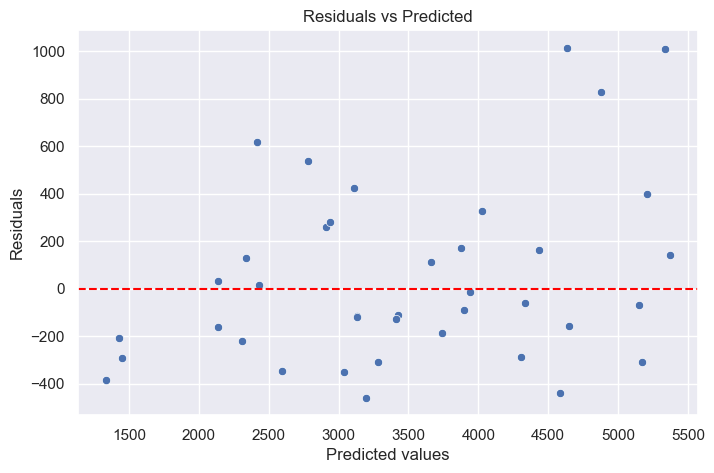

In [137]:
linear.fit(x_train, y_train)
y_pred = model.predict(x_validation)

residuals = y_validation - y_pred

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()


## Feature Importance

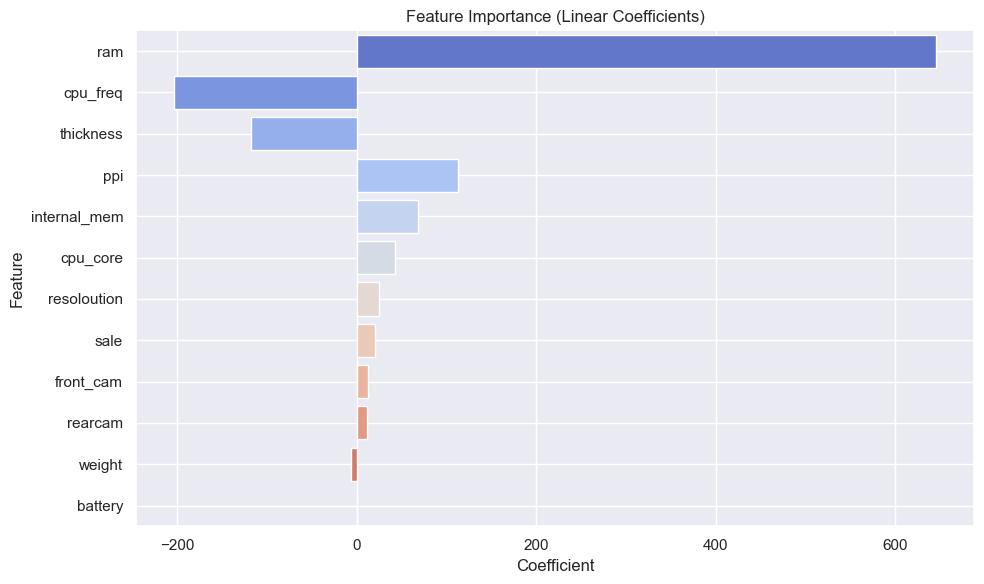

In [138]:
feature_names = x_train.columns
coefficients = linear.coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x="Coefficient", y="Feature", palette="coolwarm")
plt.title("Feature Importance (Linear Coefficients)")
plt.grid(True)
plt.tight_layout()
plt.show()

## linear_model  actual v/s Predicted comparison

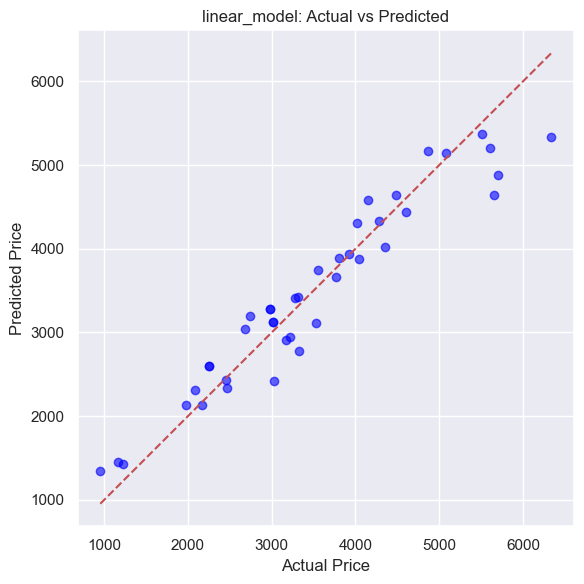

In [139]:
y_pred = linear.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("linear_model: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Lasso

## Grid Search for Hyperparameter Tuning in Lasso Regression

In [388]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100
best_score = float('-inf')
best_alpha = None

# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(lasso, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #scores = cross_val_score(lasso, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


Best Alpha: 0.013219411484660288
Best Cross-Validation Score (Negative MSE): -0.15022264729309776
Actual MSE: 0.15022264729309776


In [389]:
#Approach2 # To be used with Lasso() not with LassoCV()
lassol1 = Lasso()
alpha_range = {'alpha': [0.01, 0.1, 0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=lassol1, param_grid=alpha_range, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

Best Alpha: 0.01
Best Cross-Validation Score: -0.15095374361102581


## Model Buildiong Lasso Regression (L1 Regularization)

In [ ]:
#model  = model_performance(model=Lasso(alpha=1),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
#model  = model_performance(model=LassoCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

## lasso  actual v/s Predicted comparison

In [ ]:
y_pred = lasso.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("lasso: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ridge

## Grid Search for Hyperparameter Tuning in Ridge Regression

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(ridge, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    #scores = cross_val_score(ridge, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
#Approach2 # To be used with Ridge() not with RidgeCV()

ridge_model = Ridge()
alpha_range = {'alpha': [0.01, 0.1, .2,.3,.4,.5,.6,.7,.8,.9,1, 10, 100, 1000]}
#alpha_range = {'alpha': np.logspace(-4, 2, 100)}
grid_search = GridSearchCV(estimator=ridge_model, param_grid=alpha_range, cv=68, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

## Ridge Regression (L2 Regularization)

In [ ]:
#model = model_performance(model=Ridge(alpha=10.722672220103231),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model  = model_performance(model=RidgeCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

## ridge  actual v/s Predicted comparison

In [ ]:
y_pred = ridge.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("ridge: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## Grid Search for Hyperparameter Tuning in ElasticNet Regression

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    elastic = ElasticNet(alpha=alpha)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(elastic, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    #scores = cross_val_score(elastic, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best KFold: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
#Grid Search for Hyperparameter Tuning in Elastic net Regression

elastic_model = ElasticNet()
alpha_range = {'alpha': [0.01,0.02,0.04,0.04, 0.1, .2,.3,.4,.5,.6,.7,.8,.9,1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=elastic_model, param_grid=alpha_range, cv=68, scoring='neg_mean_squared_error')
grid_search.fit(x_train, y_train)
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print("Best Alpha:", best_alpha)
print("Best Cross-Validation Score:", best_score)

In [ ]:
# Elastic Net Regression (L1 and L2 Regularization)
#model_performance(model=ElasticNet(alpha=0.0012328467394420659),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model_performance(model=ElasticNetCV(cv=5),x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

elastic = ElasticNet(alpha=0.0012328467394420659)
#elastic = ElasticNetCV(cv=5)
elastic.fit(x_train,y_train)

elastic_predict_train_data = elastic.predict(x_train)
elastic_predict_validate_data = elastic.predict(x_validation)

coefficients = pd.Series(elastic.coef_, index=pd.DataFrame(x_train).columns)
features_elastic = coefficients[coefficients != 0].sort_values(key=np.abs, ascending=False)

elastic_mse_validate = mean_squared_error(y_validation,elastic_predict_validate_data)  #  Test Error
elastic_mse_train = mean_squared_error(y_train,elastic_predict_train_data)             #  Train Error

elastic_r2_validate = r2_score(y_validation,elastic_predict_validate_data)
elastic_r2_train = r2_score(y_train,elastic_predict_train_data)

#print("Coefficints are:\n",coefficients)
#print("\nCoefficints are:\n",features_elastic)

print("\nAccuracy Scores for Elastic net Regression (L1 Regularization) model on raw data::")
if(hasattr(lasso, "alpha")):
        print("->Alpha are:",lasso.alpha)
if(hasattr(lasso, "alpha_")):
        print("->Alpha are:",lasso.alpha_)
print("->elastic_mean square error_train_data:", elastic_mse_train)
print("->elastic_mean square error_test_data:", elastic_mse_validate)

print("->elastic_r2 square error_train_data:", elastic_r2_train)
print("->elastic_r2 square error_test_data:", elastic_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

In [ ]:
#elastic  actual v/s Predicted comparison

y_pred = elastic.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("elastic: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## GridSearchCV for Decision Tree Regressor

In [ ]:

dtree = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_leaf': [5, 10, 15, 20]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=dtree,
                           param_grid=param_grid,
                           cv=10,
                           scoring='neg_mean_squared_error',  # or use 'r2'
                           n_jobs=-1)

# Fit to the training data
grid_search.fit(x_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best MSE Score:", -grid_search.best_score_)

In [ ]:
#Approach1# Define a wide range of alpha values on a log scale
alphas = np.logspace(-4, 2, 100)  # 0.0001 to 100

best_score = float('-inf')
best_alpha = None
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# Loop through alphas and use cross-validation to find the best
for alpha in alphas:
    #elastic = ElasticNet(alpha=alpha)
    dtree = DecisionTreeRegressor(random_state=42)
    # Use negative MSE as scoring (standard in sklearn)
    scores = cross_val_score(dtree, x_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    #scores = cross_val_score(elastic, x_train, y_train, cv=5, scoring='r2')
    mean_score = scores.mean()

    if mean_score > best_score:  # since scores are negative
        best_score = mean_score
        best_alpha = alpha

print(f"Best KFold: {kfold}")
print(f"Best Alpha: {best_alpha}")
print(f"Best Cross-Validation Score (Negative MSE): {best_score}")
print(f"Actual MSE: {abs(best_score)}")


In [ ]:
# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree = DecisionTreeRegressor(ccp_alpha=0.0001,max_depth=5, min_samples_leaf=5, random_state=42)
#model_performance(model=dtree,x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)
model_performance(model=dtree,x_train=x_train,y_train=y_train,x_validation=x_validation,y_validation=y_validation)

####################################################################################
dtree.fit(x_train,y_train)
dtree_predict_train_data = dtree.predict(x_train)
dtree_predict_validation_data = dtree.predict(x_validation)

dtree_mse_validate = mean_squared_error(y_validation,dtree_predict_validation_data)  #  Test Error
dtree_mse_train = mean_squared_error(y_train,dtree_predict_train_data)             #  Train Error


dtree_r2_validate = r2_score(y_validation,dtree_predict_validation_data)
dtree_r2_train = r2_score(y_train,dtree_predict_train_data)

r2_scores = cross_val_score(dtree, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Decission Tree regression model on raw data::")
print("->Dtree_mean square error_train_data:", dtree_mse_train)
print("->Dtree_mean square error_test_data:", dtree_mse_validate)

print("->Dtree_r2 square error_train_data:", dtree_r2_train)
print("->Dtree_2 square error_test_data:", dtree_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

In [ ]:
#dtree  actual v/s Predicted comparison

y_pred = dtree.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("dtree: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Random Forest

## GridSearchCV for Random Forest Regressor

In [426]:
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [7, 9, 11],
    'min_samples_leaf': [5, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['squared_error', 'absolute_error']
}
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(x_train, y_train)

print("Best Random Forest Parameters:", rf_grid_search.best_params_)
print("Best Random Forest CV R² Score:", rf_grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Random Forest Parameters: {'bootstrap': False, 'criterion': 'squared_error', 'max_depth': 9, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest CV R² Score: 0.9019634150220609


## RandomSearchCV for Random Forest Regressor

In [434]:
rf = RandomForestRegressor()
search = RandomizedSearchCV(estimator=rf, param_distributions=rf_param_grid, 
                            n_iter=50, cv=5, verbose=2, n_jobs=-1)
search.fit(x_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': [7, 9, 11],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   verbose=2)

## Model Tuning

In [438]:
rforest = RandomForestRegressor(bootstrap=False, max_depth=11, max_features='sqrt',
                      min_samples_leaf=5, min_samples_split=5,
                      n_estimators=300)
rforest.fit(x_train,y_train)

rforest_predict_train_data = rforest.predict(x_train)
rforest_predict_validation_data = rforest.predict(x_validation)

rforest_mse_validate = mean_squared_error(y_validation,rforest_predict_validation_data)  #  Test Error
rforest_mse_train = mean_squared_error(y_train,rforest_predict_train_data)             #  Train Error

rforest_r2_validate = r2_score(y_validation,rforest_predict_validation_data)
rforest_r2_train = r2_score(y_train,rforest_predict_train_data)

r2_scores = cross_val_score(rforest, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Random Forest regression model on raw data::")
print("->rforest_mean square error_train_data:", rforest_mse_train)
print("->rforest_mean square error_test_data:", rforest_mse_validate)

print("->rforest_r2 square error_train_data:", rforest_r2_train)
print("->rforest_2 square error_test_data:", rforest_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

Crooss Val score R² for each fold: [0.90756623 0.92686101 0.89188427 0.85348723 0.92495482 0.87260718
 0.97551624 0.92703266]
Crooss Val score Average R²: 0.9099887034332891

Accuracy Scores for Random Forest regression model on raw data::
->rforest_mean square error_train_data: 0.03222208195923321
->rforest_mean square error_test_data: 0.0422985097279571
->rforest_r2 square error_train_data: 0.9678693084323411
->rforest_2 square error_test_data: 0.9562220390412584

MSE Value are : 
Less than 0 -> Good 
1-2-->Better
2-3 -> Average


## Random forest  actual v/s Predicted comparison

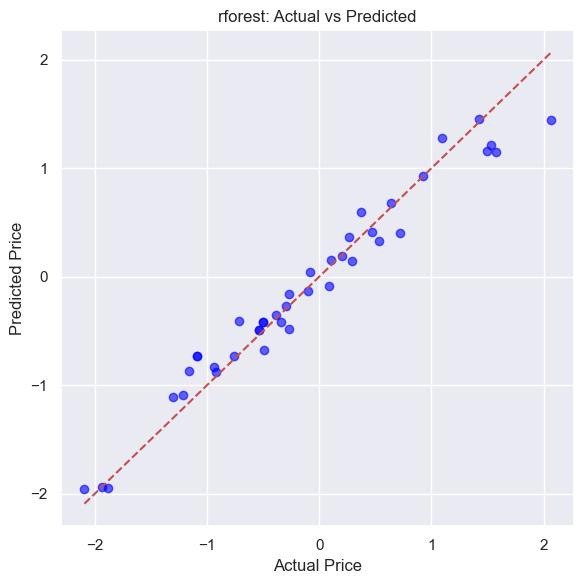

In [445]:
y_pred = rforest.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("rforest: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Gradient Boosting

## GridSearchCV for Gradient Boosting Regressor

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb_param_grid = {
    'n_estimators': [100, 200, 300, 400],         # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],      # Step size shrinkage
    'max_depth': [3, 5, 7, 9],                    # Max depth of individual estimators
    'min_samples_split': [2, 5, 10],              # Min samples to split an internal node
    'min_samples_leaf': [1, 3, 5],                # Min samples at leaf node
    'subsample': [0.6, 0.8, 1.0],                 # Fraction of samples to use for fitting each base learner
    'max_features': ['sqrt', 'log2', None],       # Number of features to consider per split
    'loss': ['squared_error', 'absolute_error']   # Loss function
}

gb_grid_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
gb_grid_search.fit(x_train, y_train)
print("Best Gradient Boosting Parameters:", gb_grid_search.best_params_)
print("Best Gradient Boosting CV R² Score:", gb_grid_search.best_score_)

Fitting 5 folds for each of 10368 candidates, totalling 51840 fits


## RandomSearchCV for Gradient Boosting Regressor

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

gb = GradientBoostingRegressor()

gb_search = RandomizedSearchCV(
    estimator=gb,
    param_distributions=gb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
gb_search.fit(x_train, y_train)

## Model Tuning

In [399]:
# Gradient Boosting Regression model
gboost = GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42)
gboost.fit(x_train,y_train)

gboost_predict_train_data = gboost.predict(x_train)
gboost_predict_validation_data = gboost.predict(x_validation)

gboost_mse_validate = mean_squared_error(y_validation,gboost_predict_validation_data)  #  Test Error
gboost_mse_train = mean_squared_error(y_train,gboost_predict_train_data)             #  Train Error

gboost_r2_validate = r2_score(y_validation,gboost_predict_validation_data)
gboost_r2_train = r2_score(y_train,gboost_predict_train_data)

r2_scores = cross_val_score(gboost, x_train, y_train, cv=8, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for Gradient Boosting Regression model on raw data::")
print("->gboost_mean square error_train_data:", gboost_mse_train)
print("->gboost_mean square error_test_data:", gboost_mse_validate)

print("->gboost_r2 square error_train_data:", gboost_r2_train)
print("->gboost_2 square error_test_data:", gboost_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

Crooss Val score R² for each fold: [0.92301045 0.94227458 0.89655436 0.87344132 0.94926965 0.94831989
 0.97572909 0.94061234]
Crooss Val score Average R²: 0.9311514604159693

Accuracy Scores for Gradient Boosting Regression model on raw data::
->gboost_mean square error_train_data: 0.014673250242952796
->gboost_mean square error_test_data: 0.030173287255670617
->gboost_r2 square error_train_data: 0.9853683669960285
->gboost_2 square error_test_data: 0.9687713586135499

MSE Value are : 
Less than 0 -> Good 
1-2-->Better
2-3 -> Average


## Gradient Boost  actual v/s Predicted comparison

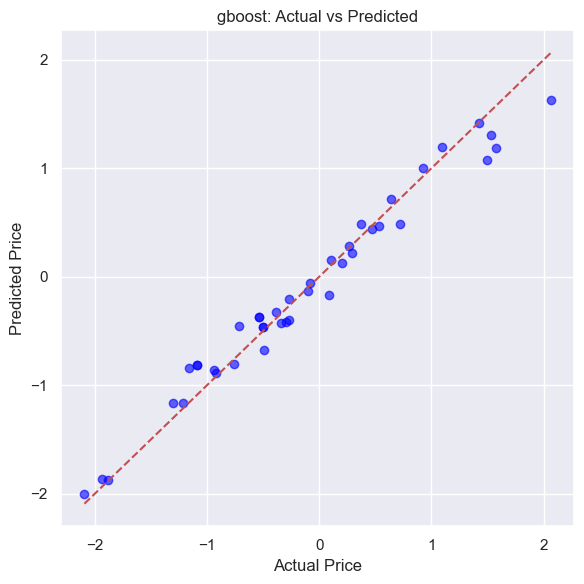

In [400]:
y_pred = gboost.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("gboost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost

## GridSearchCV for XGBoost Regressor

In [ ]:
xgboost = xgb.XGBRegressor(random_state=42)

xgb_param_grid = {
    'n_estimators': [100, 200, 300, 400],              # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Shrinkage rate
    'max_depth': [3, 5, 7, 9],                         # Maximum tree depth
    'min_child_weight': [1, 3, 5],                     # Minimum sum of instance weight (Hessian) in a child
    'subsample': [0.6, 0.8, 1.0],                      # Row subsampling
    'colsample_bytree': [0.6, 0.8, 1.0],               # Feature subsampling
    'gamma': [0, 0.1, 0.3, 0.5],                       # Minimum loss reduction for a split
    'reg_alpha': [0, 0.01, 0.1, 1.0],                  # L1 regularization
    'reg_lambda': [1.0, 1.5, 2.0],                     # L2 regularization
    'booster': ['gbtree'],                             # You can try 'dart' or 'gblinear' too
    'objective': ['reg:squarederror']                  # For regression
}

xgboost_grid_search = GridSearchCV(
    estimator=xgboost,
    param_grid=xgb_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)
xgboost_grid_search.fit(x_train, y_train)
print("Best XGBoost  Parameters:", xgboost_grid_search.best_params_)
print("Best XGBoost  CV R² Score:", xgboost_grid_search.best_score_)

Fitting 5 folds for each of 82944 candidates, totalling 414720 fits


## RandomSearchCV for XGBoost Regressor

In [9]:
xgboost = xgb.XGBRegressor(random_state=42)
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_grid,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(x_train, y_train)

NameError: name 'xgb_param_grid' is not defined

## Model Tuning

In [ ]:
# XGBoost Regression model - Max depth = 2 after testing various values
xgboost = xgb.XGBRegressor(random_state = 111, max_depth = 3)
xgboost.fit(x_train,y_train)

xgboost_predict_train_data = xgboost.predict(x_train)
xgboost_predict_validation_data = xgboost.predict(x_validation)

xgboost_mse_validate = mean_squared_error(y_validation,xgboost_predict_validation_data)  #  Test Error
xgboost_mse_train = mean_squared_error(y_train,xgboost_predict_train_data)             #  Train Error

xgboost_r2_validate = r2_score(y_validation,xgboost_predict_validation_data)
xgboost_r2_train = r2_score(y_train,xgboost_predict_train_data)

r2_scores = cross_val_score(xgboost, x_train, y_train, cv=10, scoring='r2')
print("Crooss Val score R² for each fold:", r2_scores)
print("Crooss Val score Average R²:", np.mean(r2_scores))

print("\nAccuracy Scores for XGBoost Regression model model on raw data::")
print("->xgboost_mean square error_train_data:", xgboost_mse_train)
print("->xgboost_mean square error_test_data:", xgboost_mse_validate)

print("->xgboost_r2 square error_train_data:", xgboost_r2_train)
print("->xgboost_2 square error_test_data:", xgboost_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## XBBoost  actual v/s Predicted comparison

In [ ]:
y_pred = xgboost.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# SVM- Support Vector Regression model -linear kernel

## GridSearchCV for SVM-Linear Regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid1 = {
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_grid2 = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1.0],   # Epsilon-tube within which no penalty is given
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'max_iter': [1000, 5000, 10000]     # Max number of iterations
}

param_grid3 = {
    'C': [0.01, 0.1, 1, 10, 100],        # Regularization strength
    'class_weight': [None, 'balanced'], # Handles class imbalance
    'max_iter': [1000, 5000, -1]         # Max iterations (-1 = no limit)
}

svr = SVR(kernel="linear")
grid_search = GridSearchCV(svr, param_grid2, cv=5, scoring='r2', verbose=1, n_jobs=-1)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid2,scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best R² Score:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_lin = SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale")
svr_lin.fit(x_train,y_train)

svr_lin_predict_train_data = svr_lin.predict(x_train)
svr_lin_predict_validation_data = svr_lin.predict(x_validation)

svr_lin_mse_validate = mean_squared_error(y_validation,svr_lin_predict_validation_data)  #  Test Error
svr_lin_mse_train = mean_squared_error(y_train,svr_lin_predict_train_data)             #  Train Error

svr_lin_r2_validate = r2_score(y_validation,svr_lin_predict_validation_data)
svr_lin_r2_train = r2_score(y_train,svr_lin_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - Linear kernel model on raw data::")
print("->svr_lin_mean square error_train_data:", svr_lin_mse_train)
print("->svr_lin_mean square error_test_data:", svr_lin_mse_validate)

print("->svr_lin_r2 square error_train_data:", svr_lin_r2_train)
print("->svr_lin_2 square error_test_data:", svr_lin_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## svr_lin  actual v/s Predicted comparison

In [ ]:

y_pred = svr_lin.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_lin: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# CatBoost 

# LGBMRegressor

# AdaBoostRegressor(),

# VotingRegressor(
            estimators=[('lr', LinearRegression()),('rf', RandomForestRegressor(n_estimators=100, random_state=42)),('knn', KNeighborsRegressor())])

# BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42),n_estimators=50, max_samples=0.8,max_features=0.8,random_state=42,n_jobs=-1 )

# SVM-Support Vector Regression model - Poly kernel

## GridSearchCV for SVM-Poly Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define pipeline with scaling and polynomial kernel SVR
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly'))
])

# Define hyperparameter grid for tuning
param_grid1 = {
    'svr__degree': [2, 3, 4],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1],
    'svr__coef0': [0, 1]  # Shifts polynomial curve
}

param_grid2 = {
    'C': [0.1, 1, 10, 100],                    # Regularization strength
    'epsilon': [0.01, 0.1, 0.5, 1.0],          # Epsilon-tube for tolerance in regression
    'degree': [2, 3, 4, 5],                    # Degree of the polynomial kernel
    'coef0': [0.0, 0.5, 1.0],                  # Bias term in the polynomial kernel
    'gamma': ['scale', 'auto', 0.01, 0.1, 1.0] # Kernel coefficient
}

# Perform grid search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid1,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R²:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_poly = SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4)
svr_poly.fit(x_train,y_train)

svr_poly_predict_train_data = svr_poly.predict(x_train)
svr_poly_predict_validation_data = svr_poly.predict(x_validation)

svr_poly_mse_validate = mean_squared_error(y_validation,svr_poly_predict_validation_data)  #  Test Error
svr_poly_mse_train = mean_squared_error(y_train,svr_poly_predict_train_data)             #  Train Error

svr_poly_r2_validate = r2_score(y_validation,svr_poly_predict_validation_data)
svr_poly_r2_train = r2_score(y_train,svr_poly_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - Poly kernel model on raw data::")
print("->svr_poly_mean square error_train_data:", svr_poly_mse_train)
print("->ssvr_poly_mean square error_test_data:", svr_poly_mse_validate)

print("->svr_poly_r2 square error_train_data:", svr_poly_r2_train)
print("->svr_poly_r2 square error_test_data:", svr_poly_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

# svr_poly  actual v/s Predicted comparison

In [ ]:
y_pred = svr_poly.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_poly: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# Support Vector Regression model - RBF kernel


## GridSearchCV for SVM-rbf Regressor

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

param_grid = {
    'svr__degree': [2, 3, 4],
    'svr__C': [0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1],
    'svr__coef0': [0, 1]  # Shifts polynomial curve
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated R²:", grid_search.best_score_)

## Model Tuning

In [ ]:
svr_rbf = SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf")
svr_rbf.fit(x_train,y_train)

svr_rbf_predict_train_data = svr_rbf.predict(x_train)
svr_rbf_predict_validation_data = svr_rbf.predict(x_validation)

svr_rbf_mse_validate = mean_squared_error(y_validation,svr_rbf_predict_validation_data)  #  Test Error
svr_rbf_mse_train = mean_squared_error(y_train,svr_rbf_predict_train_data)             #  Train Error

svr_rbf_r2_validate = r2_score(y_validation,svr_rbf_predict_validation_data)
svr_rbf_r2_train = r2_score(y_train,svr_rbf_predict_train_data)

print("\nAccuracy Scores for Support Vector Regression model - RBF kernel model on raw data::")
print("->svr_rbf_mean square error_train_data:", svr_rbf_mse_train)
print("->v_mean square error_test_data:", svr_rbf_mse_validate)

print("->v_r2 square error_train_data:", svr_rbf_r2_train)
print("->svr_rbf_r2 square error_test_data:", svr_rbf_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## svr_rbf  actual v/s Predicted comparison

In [ ]:
y_pred = svr_rbf.predict(x_validation)
plt.figure(figsize=(6, 6))
plt.scatter(y_validation, y_pred, alpha=0.6, color='blue')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], '--r')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("svr_rbf: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

## KNN Model Regressor

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def find_k(x_train, y_train, x_test, y_test):
    error_rate = []

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_squared_error(y_test, y_pred))

    best_k = np.argmin(error_rate) + 1
    best_mse = error_rate[best_k - 1]

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 50), error_rate, color='red', linestyle='dashed', 
             marker='o', markersize=5, markerfacecolor='blue')
    plt.axvline(x=best_k, color='green', linestyle='--', label=f'Best K = {best_k}')
    plt.title("Mean Squared Error vs K-Value")
    plt.xlabel("K-Value")
    plt.ylabel("Mean Squared Error")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Best K: {best_k} with MSE: {best_mse:.4f}")
    return best_k, best_mse


In [ ]:
find_k(x_train, y_train, x_validation, y_validation)

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assume X, y are your features and target arrays

# Standard scaling (if not done already)
scaler = StandardScaler()
#X_scaled = scaler.fit_transform(x_train)

# Try different k values
k_values = range(1, 11)
cv_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    # Negative MSE scoring, use neg_mean_squared_error and take absolute value later
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mean_score = -np.mean(scores)
    cv_scores.append(mean_score)
    print(f"k={k}, CV Mean MSE: {mean_score:.4f}")

# Find best k
best_k = k_values[np.argmin(cv_scores)]
print(f"Best k based on CV MSE: {best_k}")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Fit model on entire dataset for residual plot
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_train)

residuals = y_train - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title(f'Residual Plot for KNN Regression (k={best_k})')
plt.show()

# Optionally, print train MSE and R² for quick check
print(f"Train MSE: {mean_squared_error(y_train, y_pred):.4f}")
print(f"Train R²: {r2_score(y_train, y_pred):.4f}")
print(f"Best K: {best_k:.4f}")

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors': list(range(2, 20))}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

print("Best k:", grid.best_params_)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and prepare your dataset
# Example: mobile is a DataFrame with target column named 'target'
# Replace 'target' with the actual name of your target column
#X = mobile.drop('price', axis=1)
#y = mobile['price']

# Step 2: Train-test split
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 3: Create pipeline (StandardScaler → PCA → KNN)
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Retain 95% variance
    ('knn', KNeighborsRegressor())
])

# Step 4: Hyperparameter tuning using GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(2, 15)),
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid.fit(x_train, y_train)

# Step 5: Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(x_validation)

mse = mean_squared_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print(f"Best k: {grid.best_params_['knn__n_neighbors']}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


In [ ]:
# Building KNN regressor with k = 2
knn = KNeighborsRegressor(n_neighbors = 2)
knn.fit(x_train,y_train)

knn_predict_train_data = knn.predict(x_train)
knn_predict_validation_data = knn.predict(x_validation)

knn_mse_validate = mean_squared_error(y_validation,knn_predict_validation_data)  #  Test Error
knn_mse_train = mean_squared_error(y_train,knn_predict_train_data)             #  Train Error

knn_r2_validate = r2_score(y_validation,knn_predict_validation_data)
knn_r2_train = r2_score(y_train,knn_predict_train_data)

print("\nAccuracy Scores for KNN Regression model - RBF kernel model on raw data::")
print("->knn_mean square error_train_data:", knn_mse_train)
print("->knn_mean square error_test_data:", knn_mse_validate)

print("->knn_r2 square error_train_data:", knn_r2_train)
print("->knn_r2 square error_test_data:", knn_r2_validate)

print("\nMSE Value are : \nLess than 0 -> Good \n1-2-->Better\n2-3 -> Average")

## Full Comparison Script Ensemble Comparison


📊 Model Performance Comparison:

Decision Tree:
  -> Train MSE: 0.1084
  -> Test MSE: 0.1644
  -> Train R²: 0.8919
  -> Test R²: 0.8299

Random Forest:
  -> Train MSE: 0.0671
  -> Test MSE: 0.0685
  -> Train R²: 0.9331
  -> Test R²: 0.9291

Gradient Boosting:
  -> Train MSE: 0.0147
  -> Test MSE: 0.0302
  -> Train R²: 0.9854
  -> Test R²: 0.9688

XGBoost:
  -> Train MSE: 0.0000
  -> Test MSE: 0.0089
  -> Train R²: 1.0000
  -> Test R²: 0.9908

svr_poly:
  -> Train MSE: 0.0235
  -> Test MSE: 0.0287
  -> Train R²: 0.9766
  -> Test R²: 0.9703

svr_lin:
  -> Train MSE: 0.1417
  -> Test MSE: 0.0824
  -> Train R²: 0.8587
  -> Test R²: 0.9147

svr_rbf:
  -> Train MSE: 0.0012
  -> Test MSE: 0.0250
  -> Train R²: 0.9988
  -> Test R²: 0.9741

linear_model:
  -> Train MSE: 0.1149
  -> Test MSE: 0.0754
  -> Train R²: 0.8854
  -> Test R²: 0.9220

lasso:
  -> Train MSE: 0.1174
  -> Test MSE: 0.0722
  -> Train R²: 0.8829
  -> Test R²: 0.9253

ridge:
  -> Train MSE: 0.1178
  -> Test MSE: 0.0724
  -> T

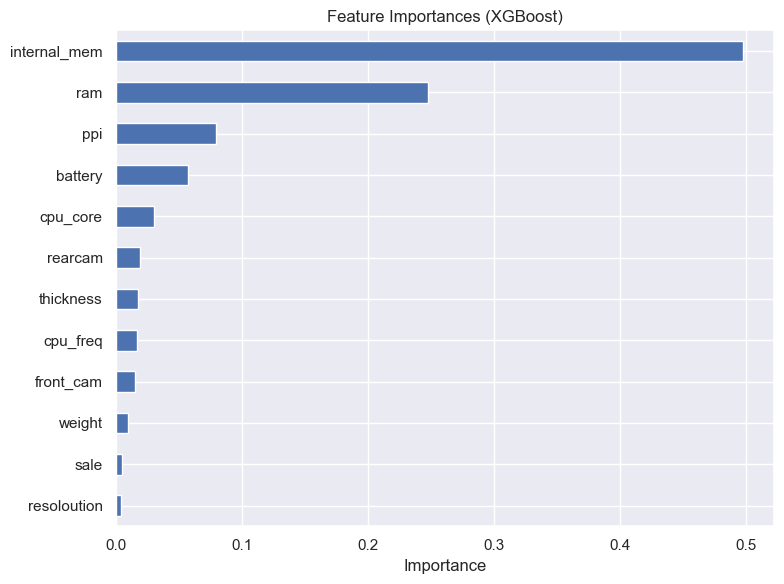

In [396]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Sample split – replace X, y with your actual dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model configurations
models = {
    'Decision Tree': DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators = 400, max_features= "sqrt",min_samples_leaf=5 ,random_state = 1, max_depth = 7),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators = 400, max_depth = 3,learning_rate=0.01,min_samples_leaf=5, random_state = 42),
    'XGBoost' : xgb.XGBRegressor(random_state = 111, max_depth = 3),
    'svr_poly': SVR(kernel ="poly",epsilon=0.01,gamma="scale",C=0.1,coef0=1,degree=4),
    'svr_lin' : SVR(kernel ="linear",C=100,epsilon=0.01,gamma="scale"),
    'svr_rbf' : SVR(C=10,coef0=0,degree=2,epsilon=0.01,kernel ="rbf"),
    'linear_model' : LinearRegression(),
    'lasso' : LassoCV(cv=5),#alpha=0.02310129700083160),
    'ridge' : RidgeCV(cv=5),
    'elastic' : ElasticNet(alpha=0.0012328467394420659)
}

# Dictionary to hold scores
results = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_validation)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_validation, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_validation, y_test_pred)

    results[name] = {
        'Train MSE': mse_train,
        'Test MSE': mse_test,
        'Train R²': r2_train,
        'Test R²': r2_test,
        'Model': model
    }

# Print results
print("\n📊 Model Performance Comparison:\n")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  -> Train MSE: {metrics['Train MSE']:.4f}")
    print(f"  -> Test MSE: {metrics['Test MSE']:.4f}")
    print(f"  -> Train R²: {metrics['Train R²']:.4f}")
    print(f"  -> Test R²: {metrics['Test R²']:.4f}")
    print("")

# Feature importance plot for the best test R² model
best_model_name = max(results, key=lambda x: results[x]['Test R²'])
best_model = results[best_model_name]['Model']

# Plot if model supports feature importances
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_names = x_train.columns if hasattr(x_train, 'columns') else [f'Feature {i}' for i in range(x_train.shape[1])]
    pd.Series(importances, index=feat_names).sort_values(ascending=True).plot(kind='barh', figsize=(8, 6))
    plt.title(f"Feature Importances ({best_model_name})")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not support feature importances.")

## Compare the Actual v/s Predicted visualization


In [ ]:
xgboost

In [ ]:
final_modell = xgboost